# Bibliotecas e Ambiente

In [19]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
from capymoa.classifier import (
    LeveragingBagging,
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    AdaptiveRandomForestClassifier
)
from capymoa.evaluation import (
    ClassificationEvaluator,
    prequential_evaluation, 
    ClassificationWindowedEvaluator,
    prequential_evaluation_multiple_learners,
    prequential_ssl_evaluation
)
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.stream import NumpyStream
from sklearn.preprocessing import LabelEncoder
from py.functions import plot_confusion_matrix, criar_stream
import random
from collections import deque
from capymoa.drift.detectors import DDM, ADWIN, ABCD
from py.models import get_models

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import re
from scipy.stats import linregress
from sklearn.metrics import f1_score # importação do f1_score

# Configuração de Avisos
warnings.filterwarnings('ignore')

# Streams

## Real

### CICDDoS2019

In [20]:
from py.functions import criar_stream

FILE_RAW = r'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv'
# FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'

TARGET_COL = " Label" # Ajuste se for o CIC-IDS2017 (sem espaço)
TIME_COL = " Timestamp" # Ajuste se for o CIC-IDS2017 (não existe)

# Colunas a serem removidas 
COLS_NAO_FEATURES = [
    'Flow ID', 
    ' Source IP', 
    ' Source Port',
    ' Destination IP', 
    ' Destination Port',
    ' Protocol'
]

TOP_20_FEATURES = [
    'Bwd Packet Length Max',
    'Min Packet Length',
    'Max Packet Length',
    'Packet Length Mean',
    'Packet Length Std',
    'Flow IAT Max',
    'Flow IAT Mean',
    'ACK Flag Count',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Init_Win_bytes_backward',
    'Bwd Packets/s',
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes',
    'Flow IAT Std',
    'Fwd IAT Total',
    'Init_Win_bytes_forward',
    'Avg Bwd Segment Size'
]

# Esta função única faz todo o trabalho de Carga, Limpeza, Ordenação e Criação
# CICDDoS2019, le_global = criar_stream(
#     file_path=FILE_RAW,
#     target_label_col=TARGET_COL,
#     timestamp_col=TIME_COL,
#     cols_para_remover=COLS_NAO_FEATURES,
#     features_selecionadas=TOP_20_FEATURES
# )

## Sintética

In [21]:
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.stream.generator import (
    RandomTreeGenerator, 
    SEA, 
    RandomRBFGenerator, 
    RandomRBFGeneratorDrift
)

# Hyperparâmetros padrão
streams = {
    "RTG": RandomTreeGenerator(
        instance_random_seed=1,
        tree_random_seed=1,
        num_classes=2,
        num_nominals=5,
        num_numerics=5,
        num_vals_per_nominal=5,
        max_tree_depth=5,
        first_leaf_level=3,
        leaf_fraction=0.15,
    ),
    
    "RTG_drift": DriftStream(
        stream=[
            RandomTreeGenerator(tree_random_seed=1),
            AbruptDrift(position=1000),
            RandomTreeGenerator(tree_random_seed=2),
            GradualDrift(position=2000, width=500),
            RandomTreeGenerator(tree_random_seed=2),
            AbruptDrift(position=3000),
            RandomTreeGenerator(tree_random_seed=2),
        ]
    ),

    "SEA_drift": DriftStream(
        stream=[
            SEA(function=1),
            AbruptDrift(position=1000),
            SEA(function=2),
            AbruptDrift(position=2000),
            SEA(function=3),
            GradualDrift(position=3000, width=500),
            SEA(function=4),
        ]
    ),

    "RandomRBF": RandomRBFGenerator(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
    ), 

    "RandomRBF_drift": RandomRBFGeneratorDrift(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
        number_of_drifting_centroids=4,
        magnitude_of_change=0.0,
    ),

    "Robust_Drift": DriftStream(
        stream=[
            # 0-2000
            RandomRBFGenerator(
                model_random_seed=1, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=50
            ),
            # 2000-4000 (Testa DDM/ADWIN)
            AbruptDrift(position=2000),
            RandomTreeGenerator(
                tree_random_seed=1, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 4000-6000 (Testa ABCD)
            AbruptDrift(position=4000),
            RandomRBFGenerator(
                model_random_seed=2, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=20
            ),
            # 6000-8000 (Testa DDM/ADWIN)
            AbruptDrift(position=6000),
            RandomTreeGenerator(
                tree_random_seed=2, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 8000-10000 (Testa ABCD)
            GradualDrift(position=8000, width=1000),
            RandomRBFGeneratorDrift(
                model_random_seed=4, 
                instance_random_seed=1, 
                number_of_attributes=10, 
                number_of_drifting_centroids=20, 
                magnitude_of_change=0.5
            )
        ]
    )

}

# Desenvolvimento e Testes

In [22]:
def extrair_rotulo_dinamico(evento_nome):
    if "BENIGN" in evento_nome:
        return "Benigno"
    nome_limpo = re.sub(r'^(ATAQUE_|NIVEL_\d+_|ATAQUE_[A-Z0-9]+_)', '', evento_nome)
    return nome_limpo

def calcular_metricas_avancadas(prediction_history, df_meta, threshold=0.95, N=100):
    metrics_data = []
    
    for _, row in df_meta[df_meta['Tipo'] == 'Ataque'].iterrows():
        start = row['Inicio']
        end = row['Fim']
        nome_evento = extrair_rotulo_dinamico(row['Evento'])
        
        limit = min(len(prediction_history), end)
        if start >= limit: continue
            
        event_preds = prediction_history[start:limit]
        
        n_limit = min(len(event_preds), N)
        acc_at_n = np.mean(event_preds[:n_limit]) * 100
        
        ttt = -1
        window_size_ttt = 100
        if len(event_preds) > window_size_ttt:
            series_preds = pd.Series(event_preds)
            rolling_acc = series_preds.rolling(window=window_size_ttt).mean()
            
            achou = rolling_acc[rolling_acc >= threshold].index
            if len(achou) > 0:
                ttt = achou[0]
        
        slope = 0
        if len(event_preds) > 10:
            y_values = [np.mean(event_preds[:i+1]) for i in range(10, n_limit)]
            x_values = np.arange(len(y_values))
            slope, _, _, _, _ = linregress(x_values, y_values)
            
        metrics_data.append({
            'Evento': nome_evento,
            'Inicio_Real': start,
            'Acc_@_N': f"{acc_at_n:.2f}%",
            'Time_to_95%': ttt if ttt != -1 else "Não atingiu",
            'Slope': f"{slope:.6f}"
        })
        
    return pd.DataFrame(metrics_data)

## Cenário 1

In [5]:
FILE_1 = r'datasets\CICDDoS2019\Experimentos\Exp_1\stream_Imunidade.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_1\metadata_Imunidade.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

In [6]:
print(f"Carregando Stream: {FILE_1}")
df_raw = pd.read_csv(FILE_1)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_1, le_global = criar_stream(
    df=df_raw, 
    target_label_col="Label" 
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_1\stream_Imunidade.csv


NameError: name 'pd' is not defined

## Cenário 2

In [ ]:
FILE_2 = r'datasets\CICDDoS2019\Experimentos\Exp_2\stream_Memoria.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_2\metadata_Memoria.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_2\stream_Memoria.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_MSSQL' 'DrDoS_UDP']
======================= LeveragingBagging =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP         5215  93.00%          104 0.002432
DrDoS_MSSQL        40430  67.00%          148 0.004333
  DrDoS_UDP        75645  83.00%          123 0.006003


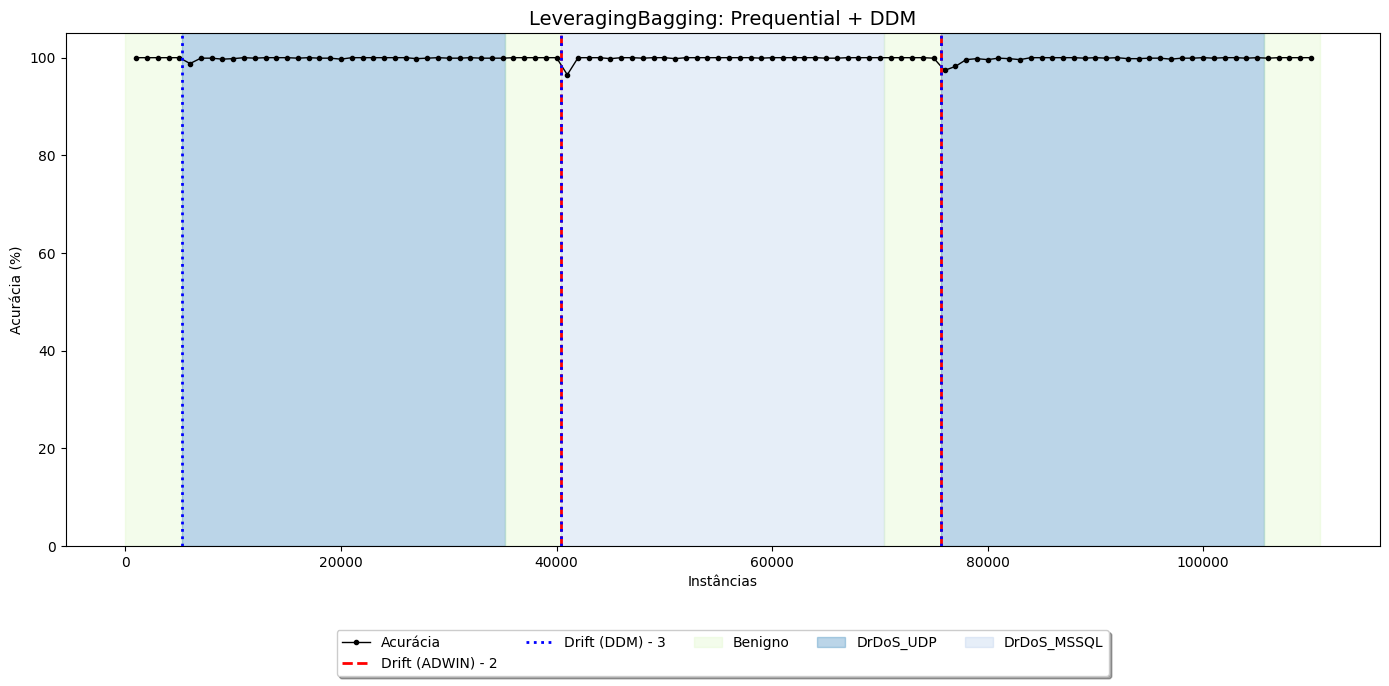

======================= HoeffdingAdaptiveTree =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP         5215  89.00%          140 0.001680
DrDoS_MSSQL        40430  62.00%          305 0.003734
  DrDoS_UDP        75645  77.00%          159 0.004879


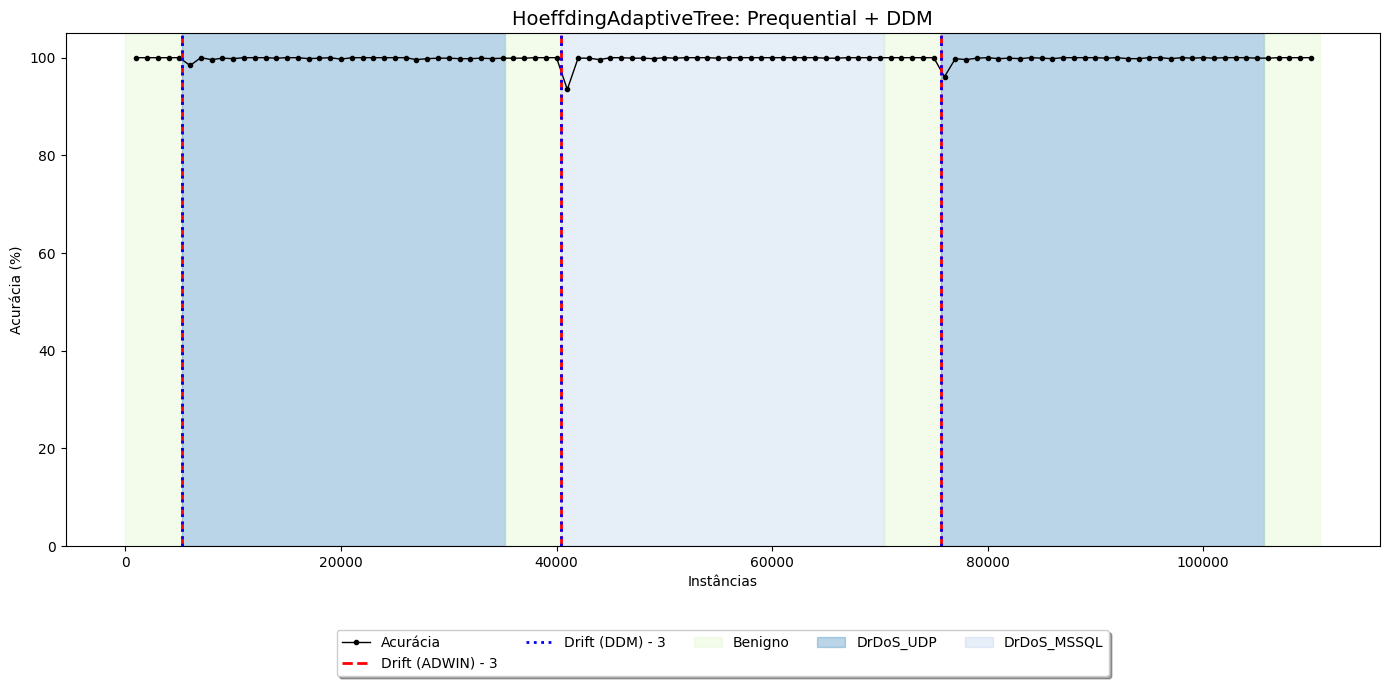

======================= AdaptiveRandomForest =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP         5215  93.00%          104 0.002432
DrDoS_MSSQL        40430  85.00%          114 0.005529
  DrDoS_UDP        75645  87.00%          115 0.005216


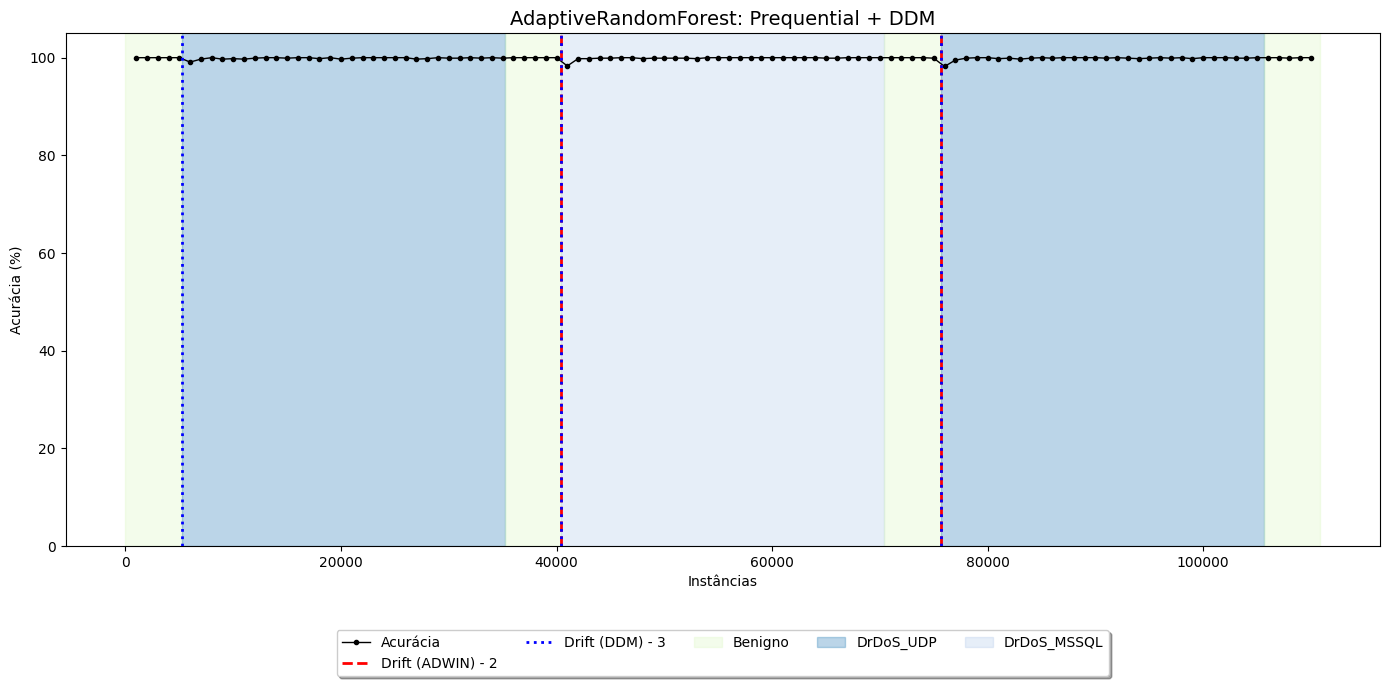

======================= HoeffdingTree =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP         5215  93.00%          104 0.002432
DrDoS_MSSQL        40430  39.00%          261 0.000249
  DrDoS_UDP        75645  84.00%          264 0.003603


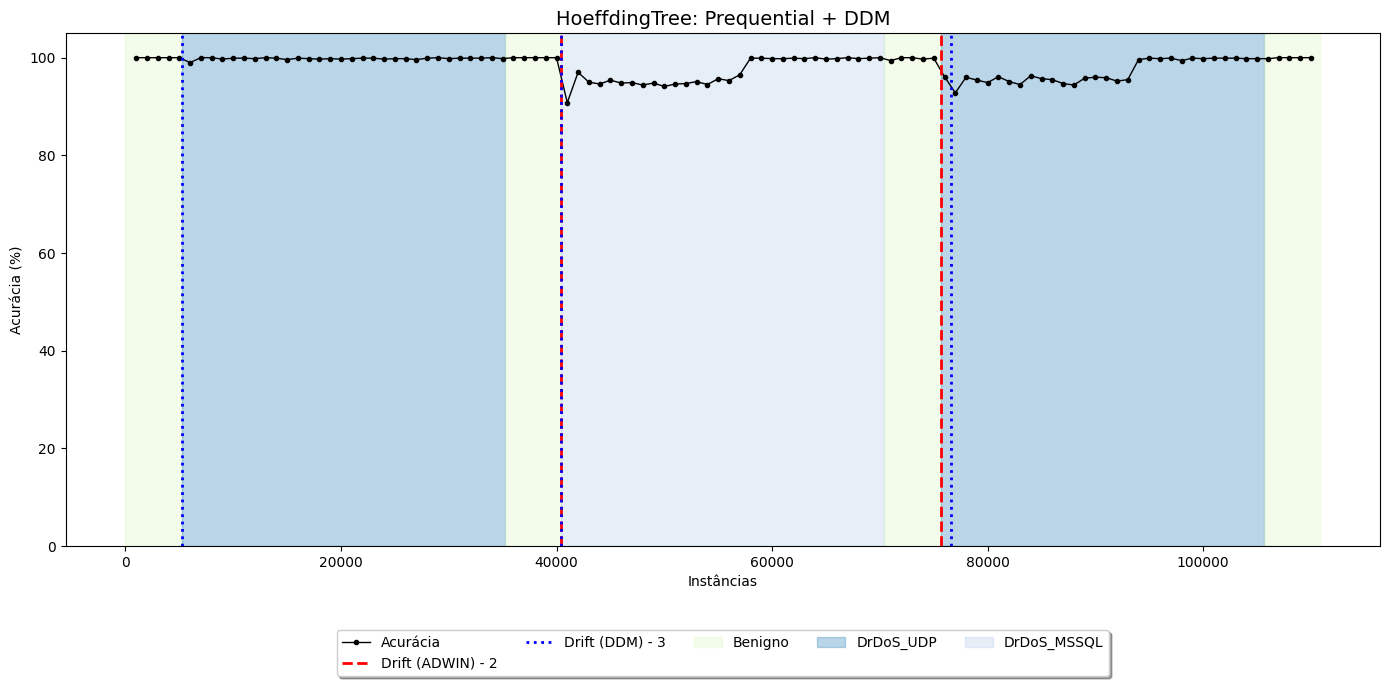

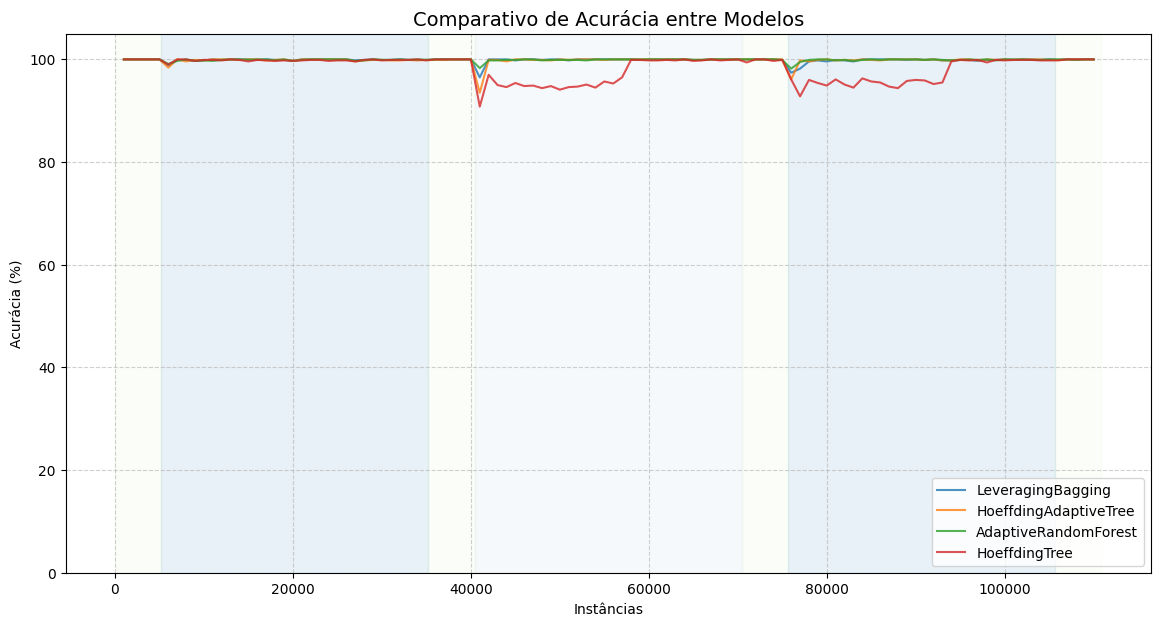

In [ ]:
print(f"Carregando Stream: {FILE_2}")
df_raw = pd.read_csv(FILE_2)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_1, le_global = criar_stream(
    df=df_raw, 
    target_label_col="Label" 
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário 3

In [ ]:
FILE_3 = r'datasets\CICDDoS2019\Experimentos\Exp_3\stream_Complexidade.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_3\metadata_Complexidade.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_3\stream_Complexidade.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_DNS' 'DrDoS_NTP']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP         5215 100.00%           99 0.000000
DrDoS_NTP        22430  89.00%          126 0.002843
DrDoS_DNS        57645  70.00%          145 0.004914


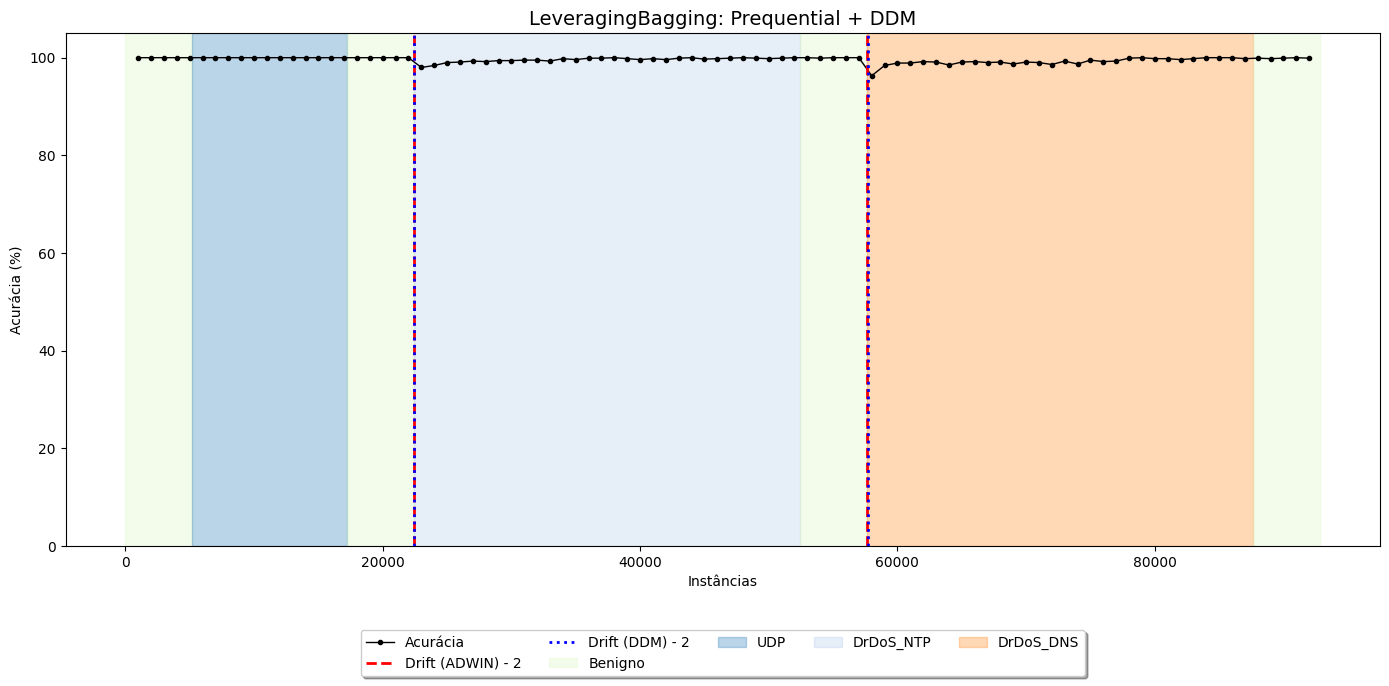

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP         5215 100.00%           99 0.000000
DrDoS_NTP        22430  90.00%          193 0.001719
DrDoS_DNS        57645  47.00%          243 0.000846


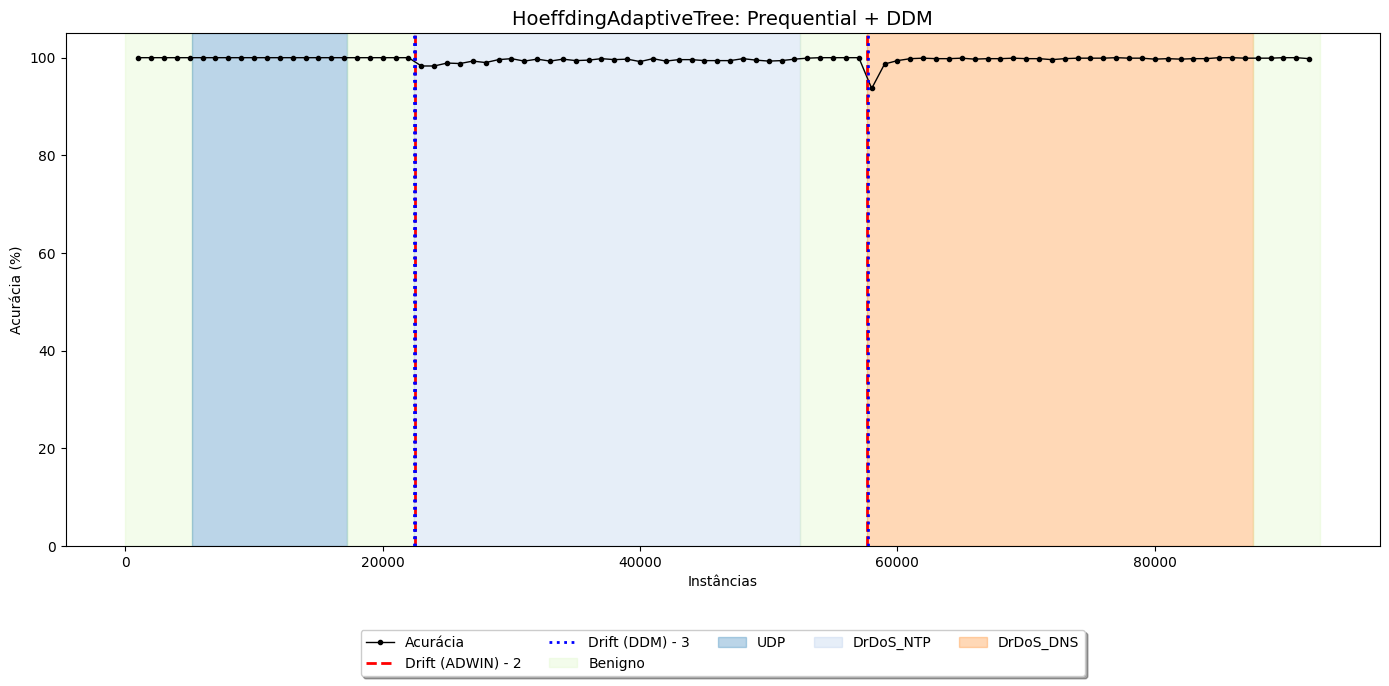

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP         5215 100.00%           99 0.000000
DrDoS_NTP        22430  91.00%          114 0.002322
DrDoS_DNS        57645  90.00%          107 0.004053


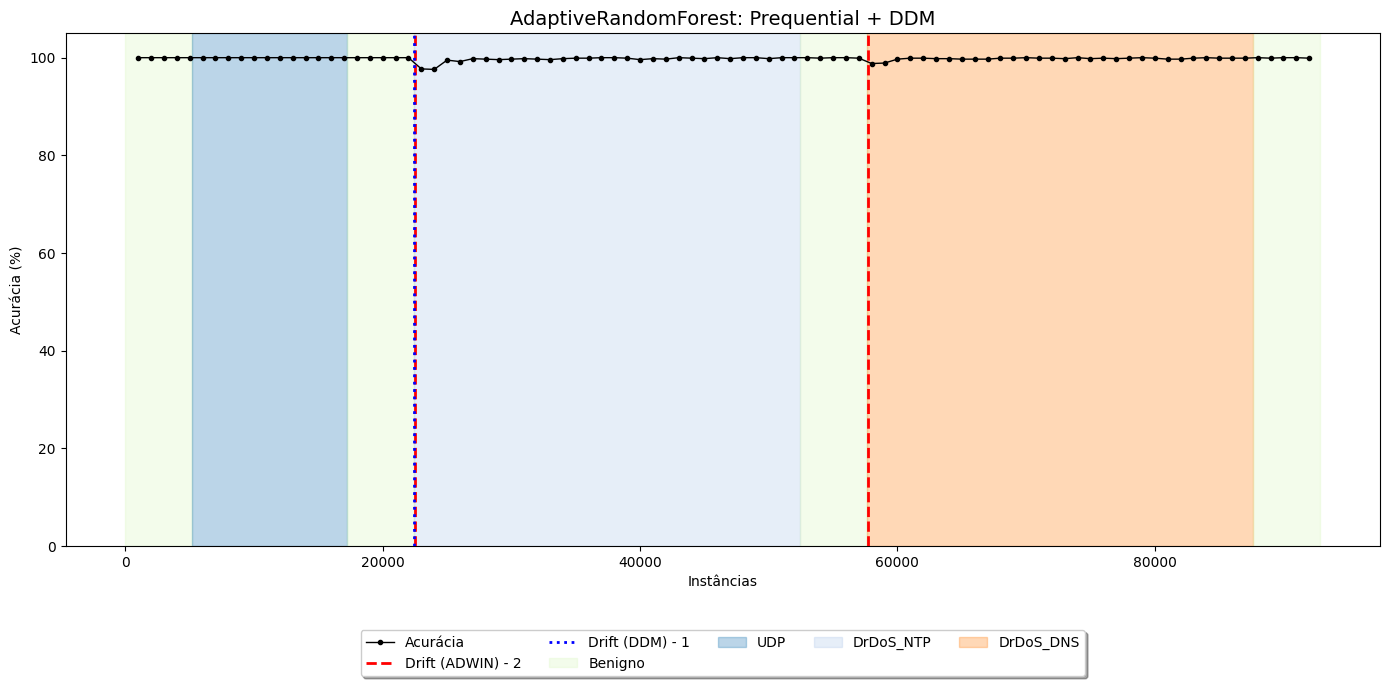

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP         5215 100.00%           99 0.000000
DrDoS_NTP        22430  94.00%          100 0.001928
DrDoS_DNS        57645  44.00%          233 0.000604


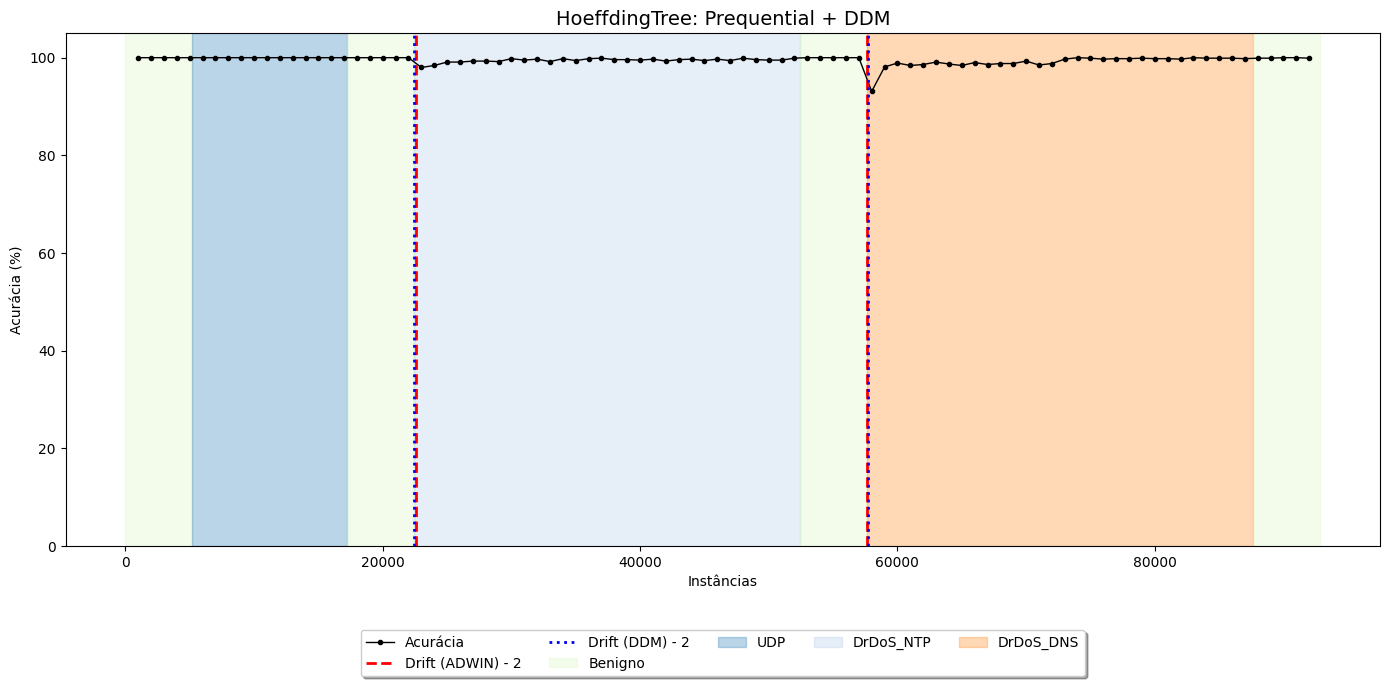

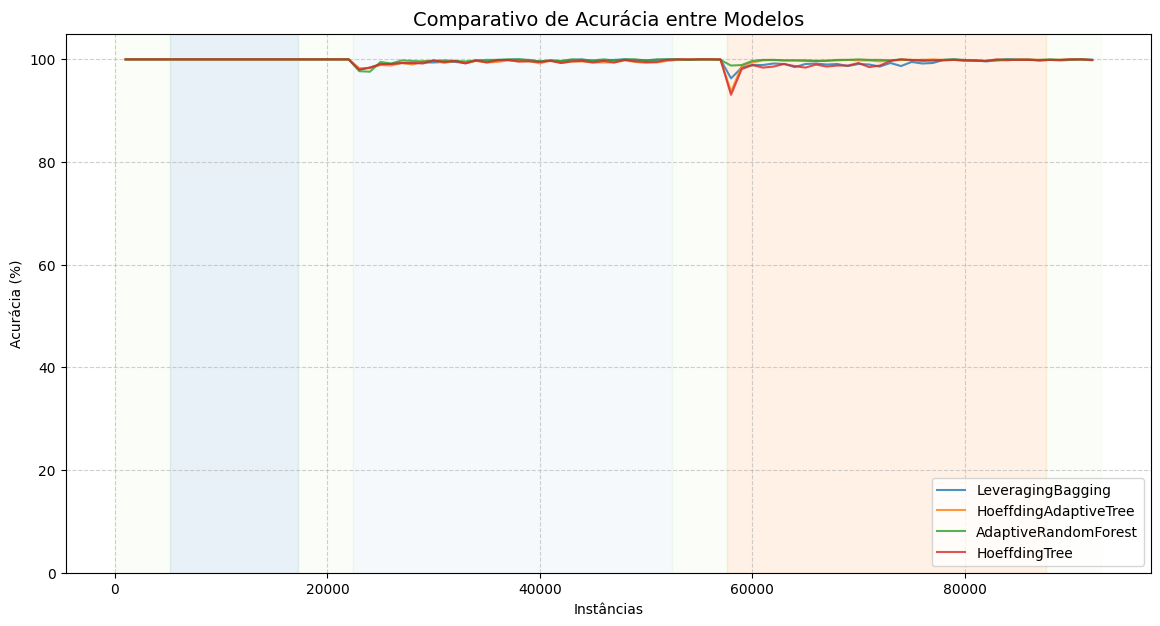

In [ ]:
print(f"Carregando Stream: {FILE_3}")
df_raw = pd.read_csv(FILE_3)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_1, le_global = criar_stream(
    df=df_raw, 
    target_label_col="Label" 
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário A (Acurácia - Teste)

In [11]:
FILE_A = r'datasets\CICDDoS2019\Experimentos\Exp_A\stream_Heterogeneidade_A.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_A\metadata_Heterogeneidade_A.csv'
WINDOW_SIZE = 50
MAX_INSTANCES = 167828

Sequencia do cenário A: [BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN]
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_A\stream_Heterogeneidade_A.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_NTP' 'Syn']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      Syn         5215  90.00%          124 0.000586
DrDoS_NTP        40430  89.00%          124 0.002800
      Syn        75645 100.00%           99 0.000000


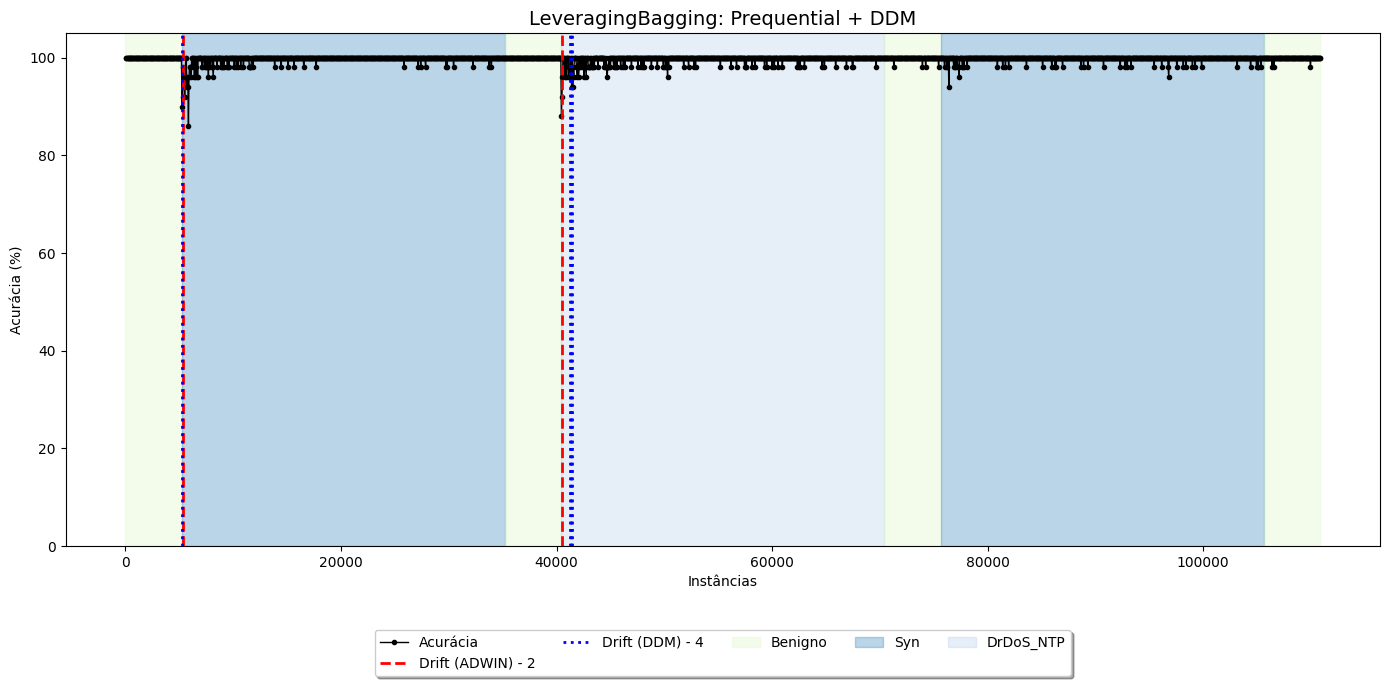

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
      Syn         5215  88.00%          145 -0.000000
DrDoS_NTP        40430  79.00%          208  0.003592
      Syn        75645  86.00%          213  0.002209


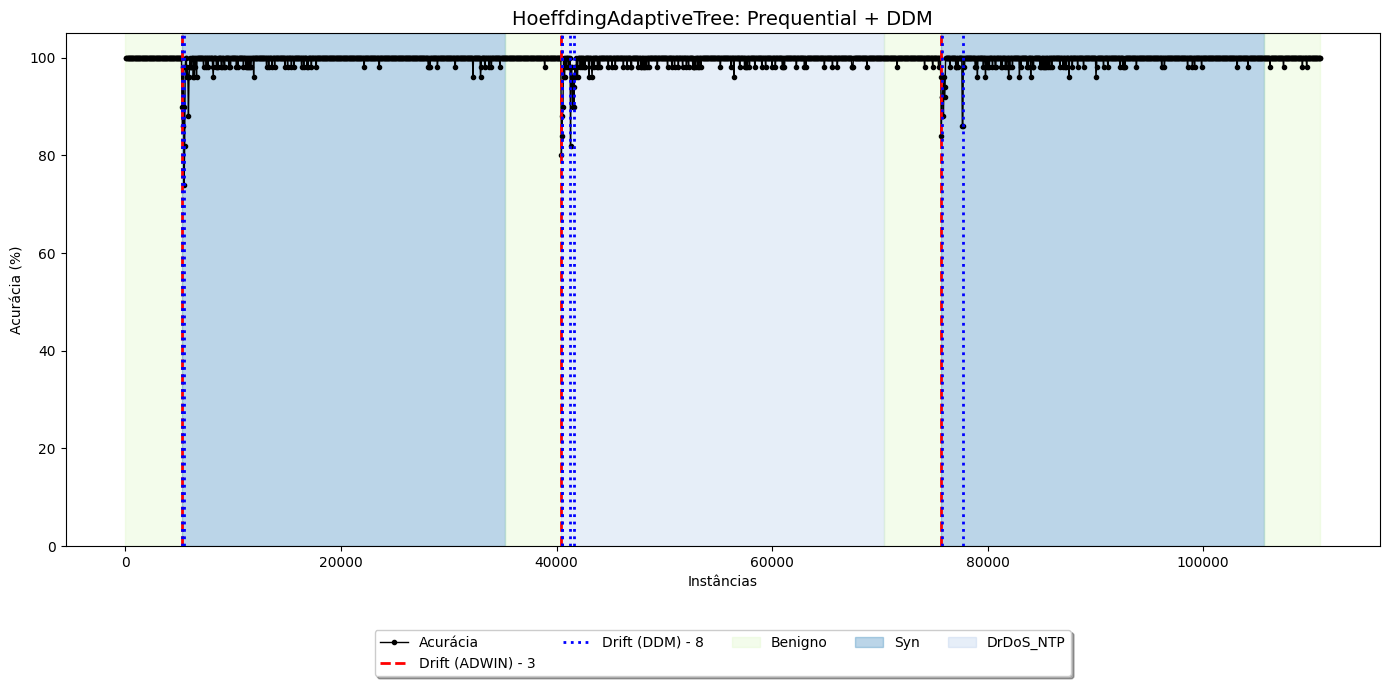

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
      Syn         5215  90.00%          132  0.000369
DrDoS_NTP        40430  92.00%          110  0.002548
      Syn        75645  99.00%           99 -0.000007


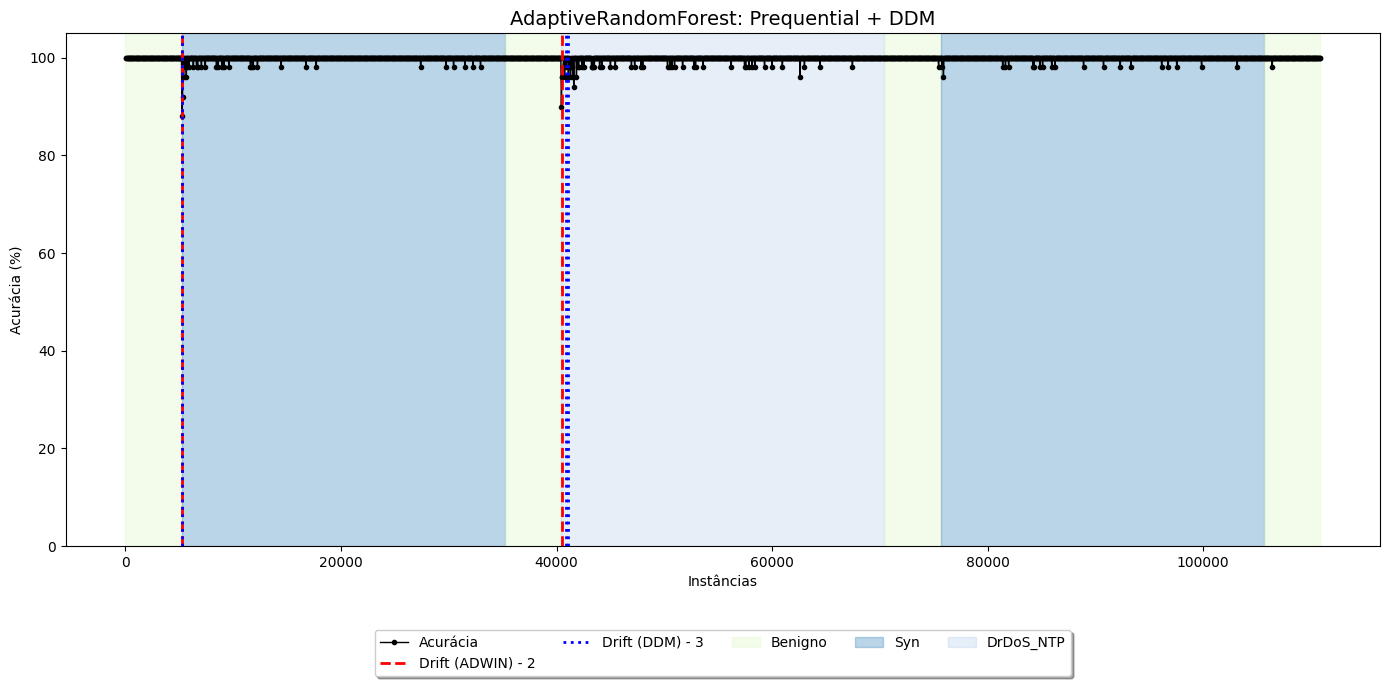

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      Syn         5215  93.00%          112 0.000947
DrDoS_NTP        40430  94.00%          100 0.001928
      Syn        75645  98.00%           99 0.001037


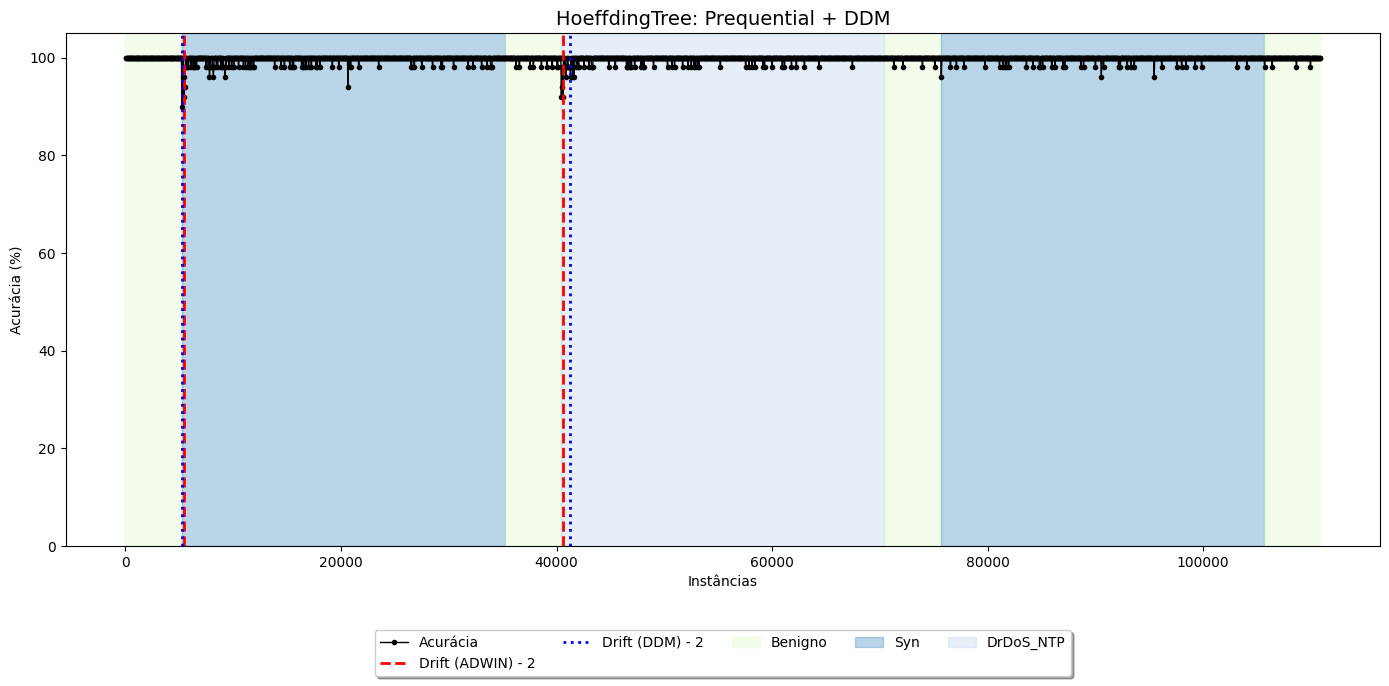

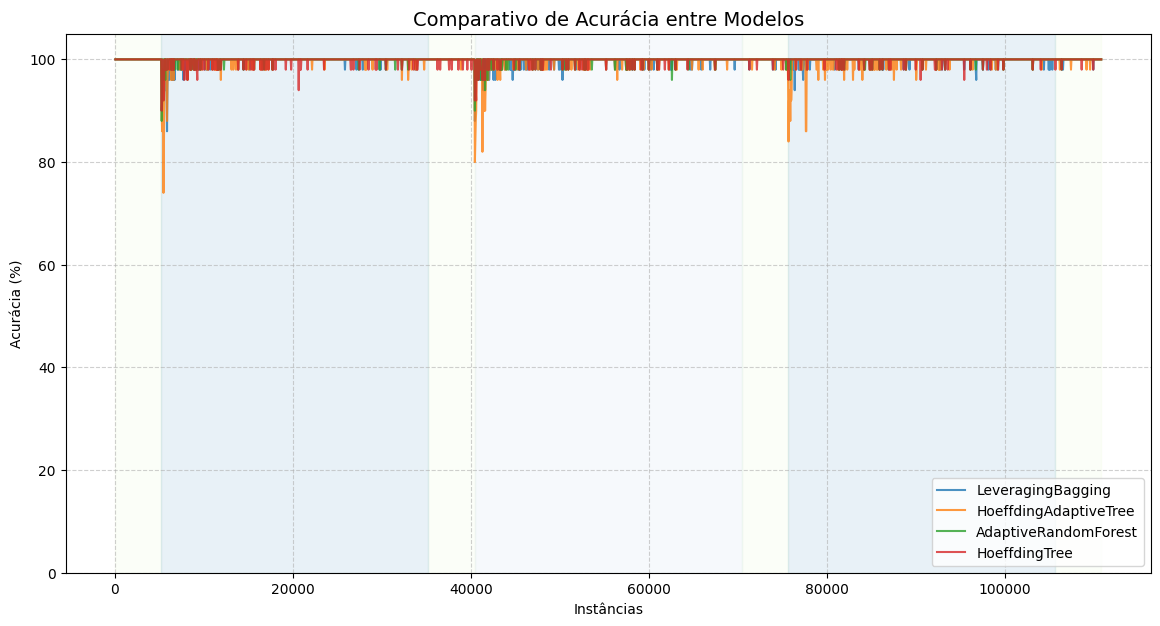

In [ ]:
print("Sequencia do cenário A: [BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN]")
print("Objetivo: Avaliar a capacidade de adaptação dos modelos a ataques com características muito distintas. Testar também a mémoria em relação a recorrências.")
print("Aqui a métrica de avaliação é acurácia. O cenário C utiliza F1-Score para o mesmo stream. " \
"A janela foi extremamente reduzida (1000 -> 50) para provocar um desbalanceamento temporário afim de destacar as diferenças entre as métricas.")
print(f"Carregando Stream: {FILE_A}")
df_raw = pd.read_csv(FILE_A)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_A, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_A.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []

instance_count_history = []
count = 0

cenario_A.restart()

while cenario_A.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_A.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-',
            label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário A (ataques diferentes: X -> Y -> X)

In [25]:
FILE_D = r'datasets\CICDDoS2019\Experimentos\Exp_A\stream_heterogeneidade_A.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_A\metadata_heterogeneidade_A.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Sequencia do cenário A: [BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN]
X -> Y -> X
Objetivo: Avaliar a capacidade de adaptação dos modelos a ataques com características muito distintas. Testar também a mémoria em relação a recorrências.
Aqui a métrica de avaliação é acurácia. O cenário C utiliza F1-Score para o mesmo stream. A janela foi extremamente reduzida (1000 -> 50) para provocar um desbalanceamento temporário afim de destacar as diferenças entre as métricas.
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_A\stream_heterogeneidade_A.csv
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_A\stream_heterogeneidade_A.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_NTP' 'Syn']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      Syn         5215  90.00%          124 0.000586
DrDoS_NTP        40430  89.00%          124 0.002800
      Syn        75645 100.00%           99 0

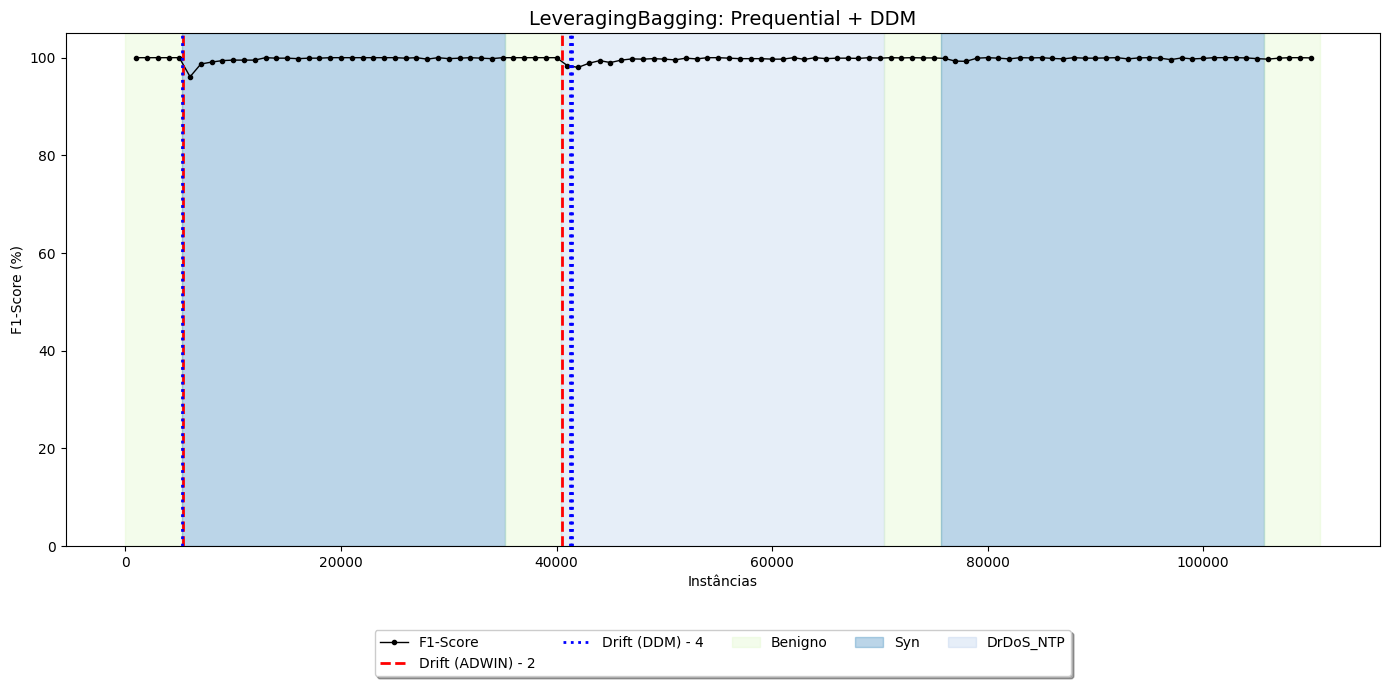

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
      Syn         5215  88.00%          145 -0.000000
DrDoS_NTP        40430  79.00%          208  0.003592
      Syn        75645  86.00%          213  0.002209


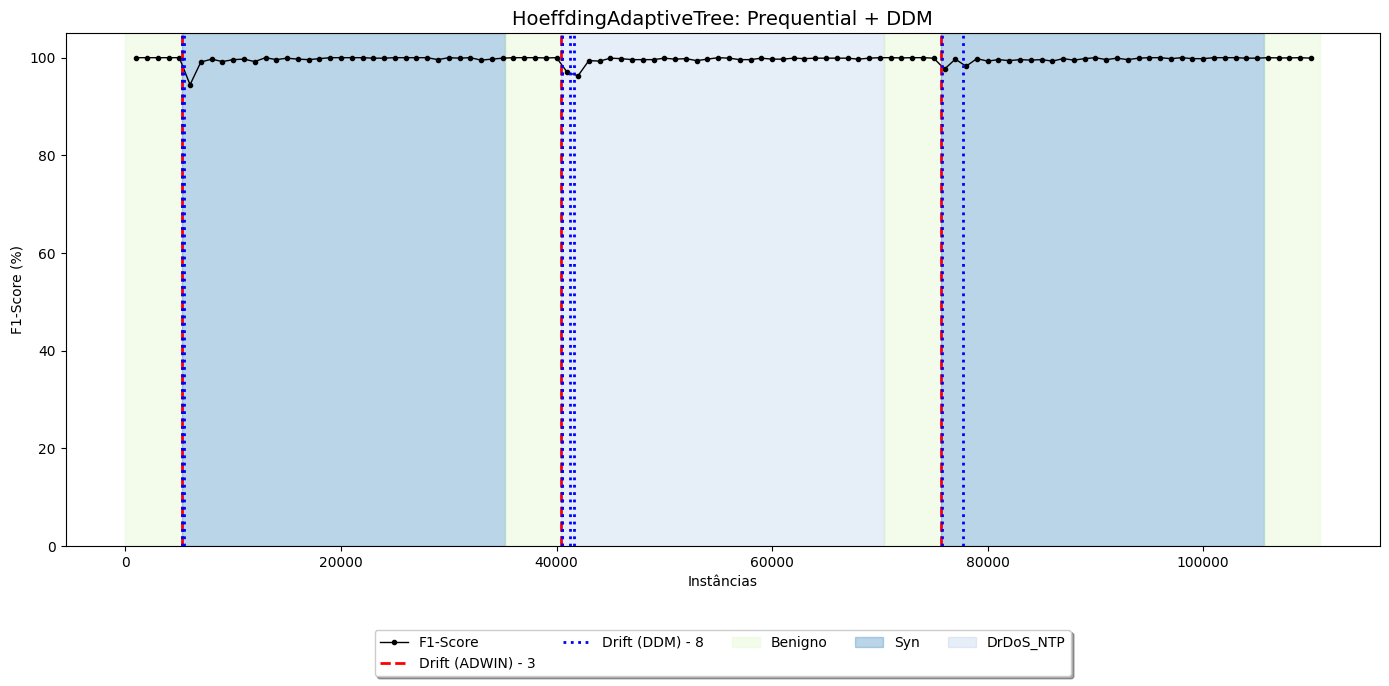

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
      Syn         5215  90.00%          132  0.000369
DrDoS_NTP        40430  92.00%          110  0.002548
      Syn        75645  99.00%           99 -0.000007


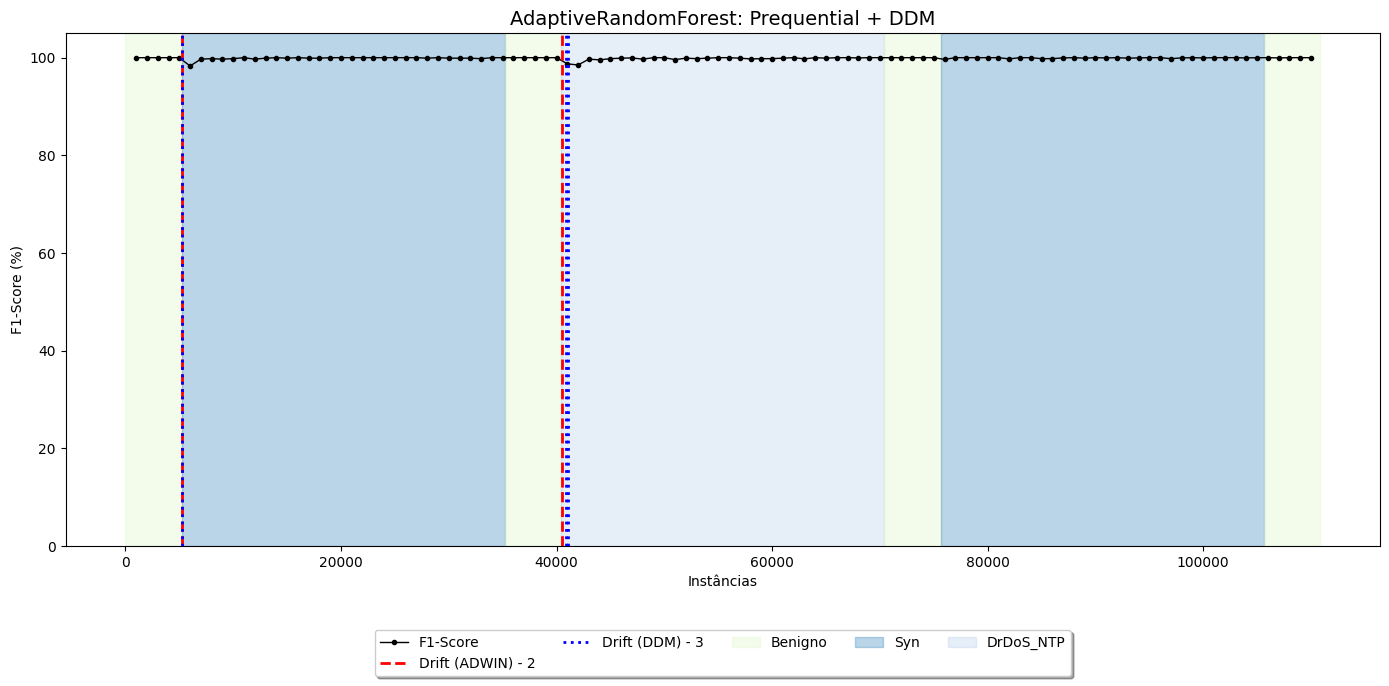

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      Syn         5215  93.00%          112 0.000947
DrDoS_NTP        40430  94.00%          100 0.001928
      Syn        75645  98.00%           99 0.001037


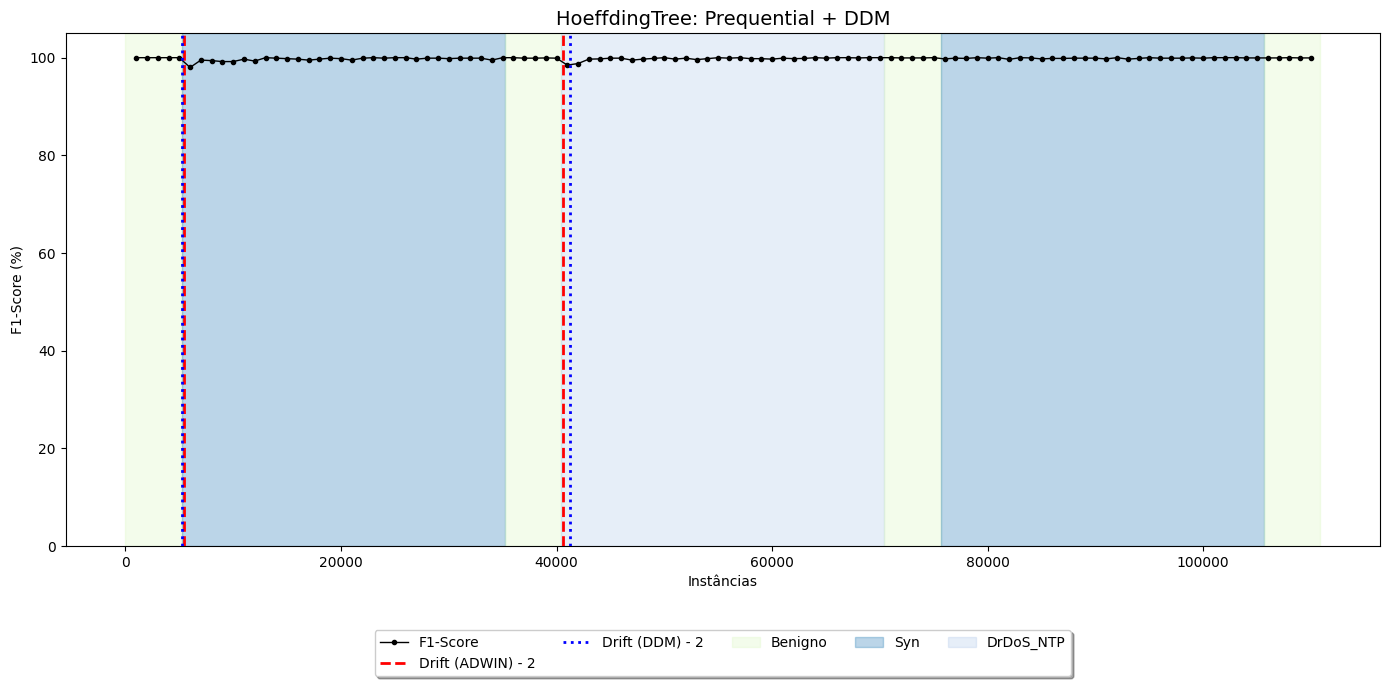

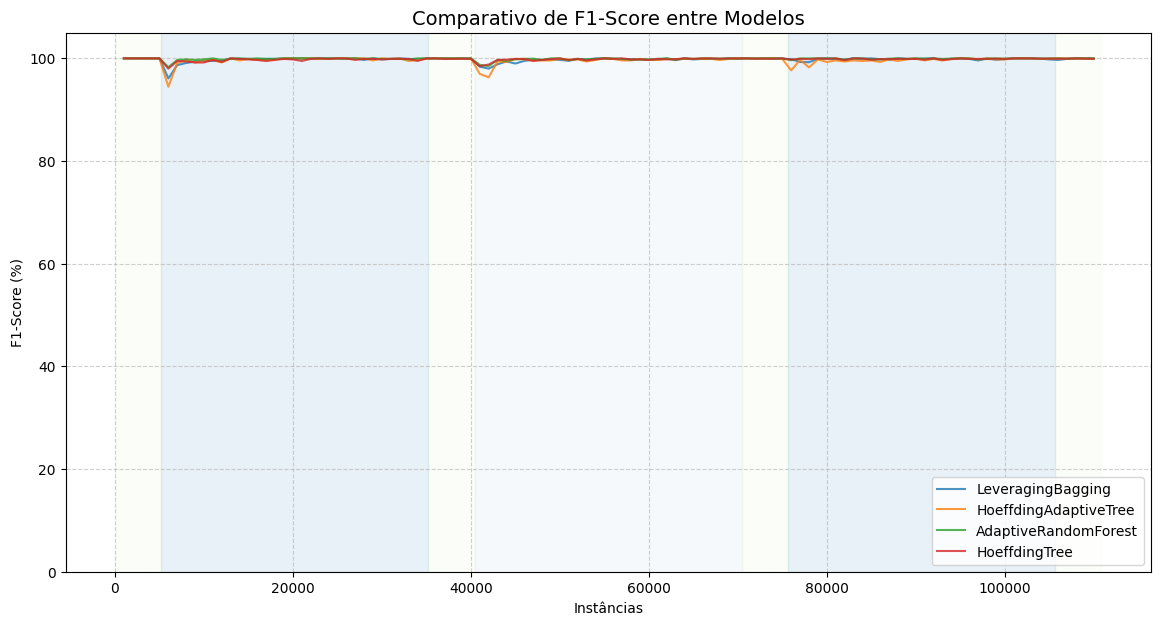

In [26]:
print("Sequencia do cenário A: [BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN]")
print("X -> Y -> X")
print("Objetivo: Avaliar a capacidade de adaptação dos modelos a ataques com características muito distintas. Testar também a mémoria em relação a recorrências.")
print("Aqui a métrica de avaliação é acurácia. O cenário C utiliza F1-Score para o mesmo stream. " \
"A janela foi extremamente reduzida (1000 -> 50) para provocar um desbalanceamento temporário afim de destacar as diferenças entre as métricas.")
print(f"Carregando Stream: {FILE_D}")
print(f"Carregando Stream: {FILE_D}")
df_raw = pd.read_csv(FILE_D)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_D, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_D.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []
    models_to_test[m_name]["window_y_true"] = []      # NOVO: valores reais da janela
    models_to_test[m_name]["window_y_pred"] = []      # NOVO: predições da janela
    models_to_test[m_name]["results_f1score"] = []    # NOVO: trocar results_accuracy
    models_to_test[m_name]["window_errors"] = []      # Manter para drift detection

instance_count_history = []
count = 0

cenario_D.restart()

while cenario_D.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_D.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)

        # NOVO: Armazenar valores reais e predições para calcular F1
        state["window_y_true"].append(instance.y_index)
        state["window_y_pred"].append(pred_val)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            # Código substituído para cálculo de F1-Score (antes era acurácia)
            # mean_acc = 1.0 - np.mean(state["window_errors"])
            # state["results_accuracy"].append(mean_acc * 100)
            # state["window_errors"].clear()

            # Código novo para cálculo de F1-Score
            # Calcular F1-Score usando sklearn
            # average='binary' para classificação binária
            # ou 'weighted' para multi-classe
            f1 = f1_score(state["window_y_true"], 
                        state["window_y_pred"], 
                        average='weighted',
                        zero_division=0) * 100
            
            state["results_f1score"].append(f1)
            
            # Limpar as janelas
            state["window_y_true"].clear()
            state["window_y_pred"].clear()
            state["window_errors"].clear()

            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Código substituído para plotar acurácia
    # ax.plot(instance_count_history, state['results_accuracy'], 'o-',
    #         label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)

    # Código novo para plotar F1-Score
    ax.plot(instance_count_history, state['results_f1score'], 'o-',
        label='F1-Score', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    # ax.set_ylabel('Acurácia (%)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(14, 7))
# for model_name, state in models_to_test.items():
#     plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_f1score'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de F1-Score entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('F1-Score (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário B (ataques diferentes: Y -> X -> Y)

In [15]:
FILE_B = r'datasets\CICDDoS2019\Experimentos\Exp_B\stream_Heterogeneidade_B.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_B\metadata_Heterogeneidade_B.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Sequencia do cenário B: [BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN]
Y -> X -> Y
Objetivo: Comparar a resposta dos modelos a um cenário de heterogeneidade similar ao cenário A, porém com a ordem dos ataques invertida. 
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_B\stream_Heterogeneidade_B.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_NTP' 'Syn']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_NTP         5215  92.00%          107 0.002648
      Syn        40430  94.00%          100 0.002054
DrDoS_NTP        75645 100.00%           99 0.000000


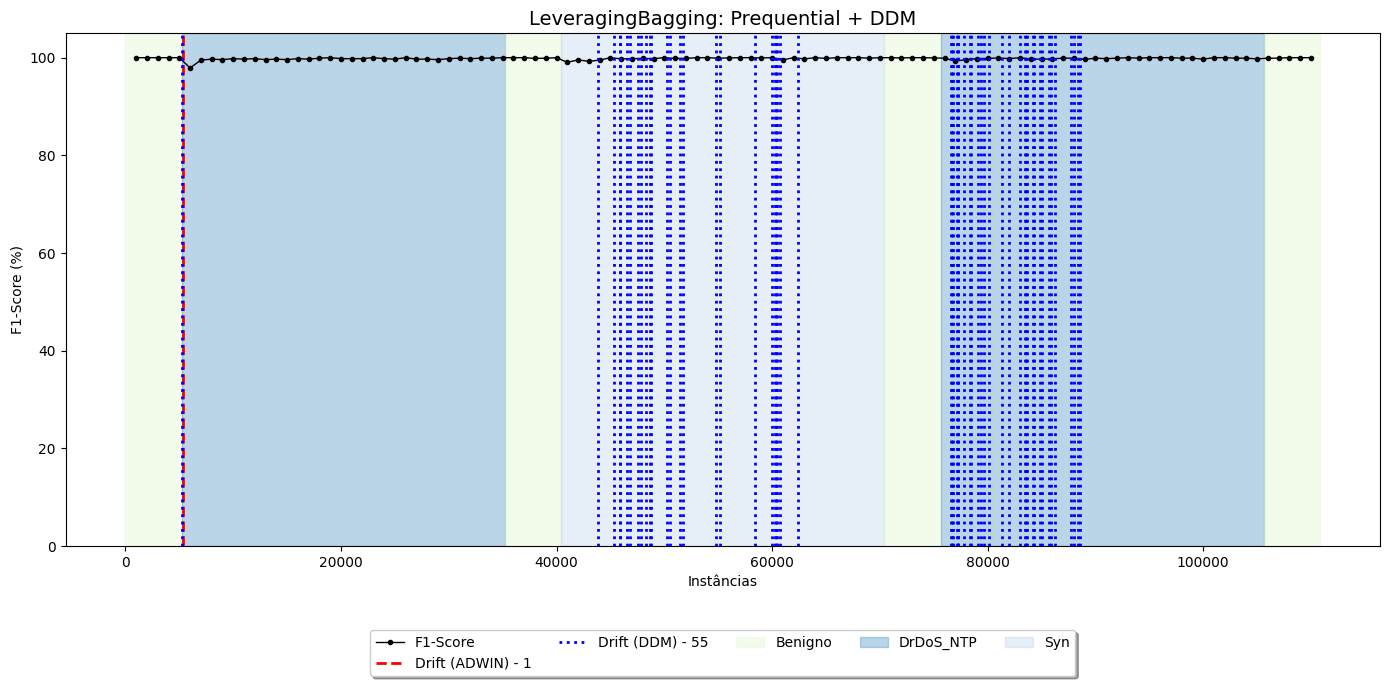

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_NTP         5215  83.00%          171 0.001067
      Syn        40430  92.00%          114 0.001836
DrDoS_NTP        75645 100.00%           99 0.000000


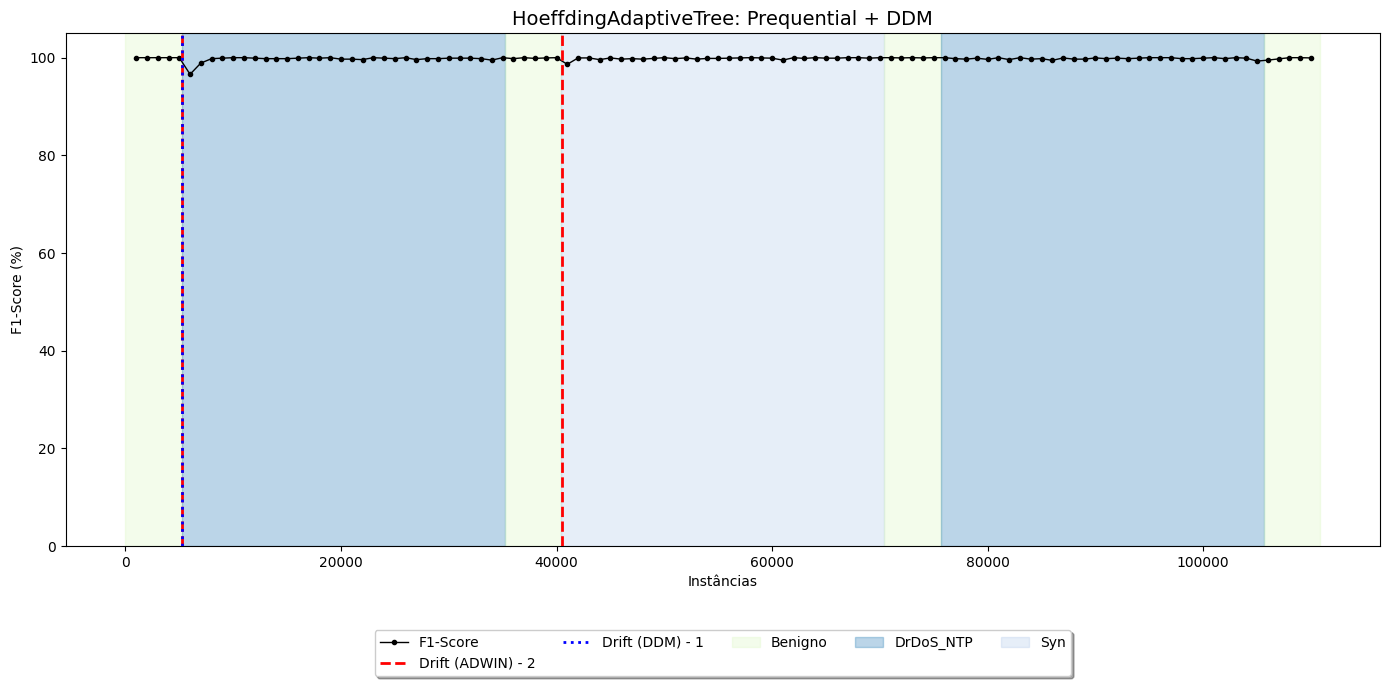

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_NTP         5215  89.00%          123 0.001891
      Syn        40430  93.00%          104 0.001939
DrDoS_NTP        75645  98.00%           99 0.000408


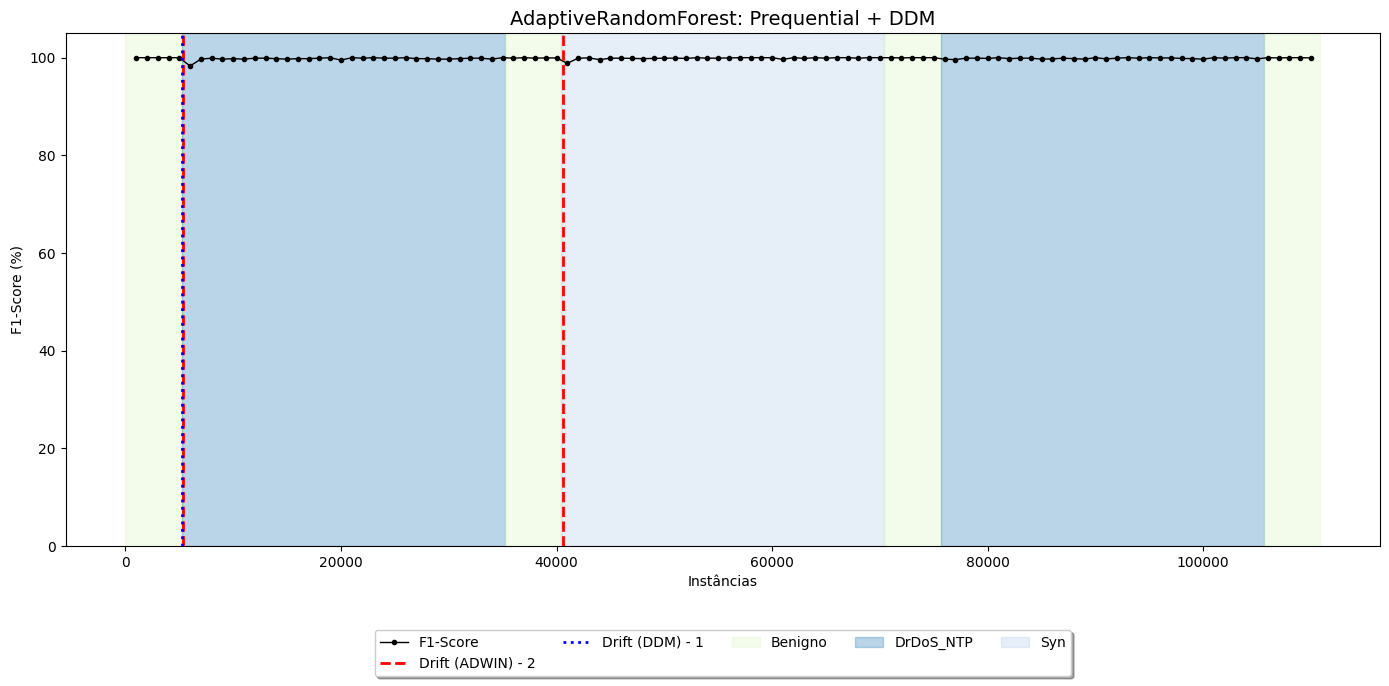

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_NTP         5215  94.00%          100 0.002233
      Syn        40430  93.00%          104 0.001955
DrDoS_NTP        75645 100.00%           99 0.000000


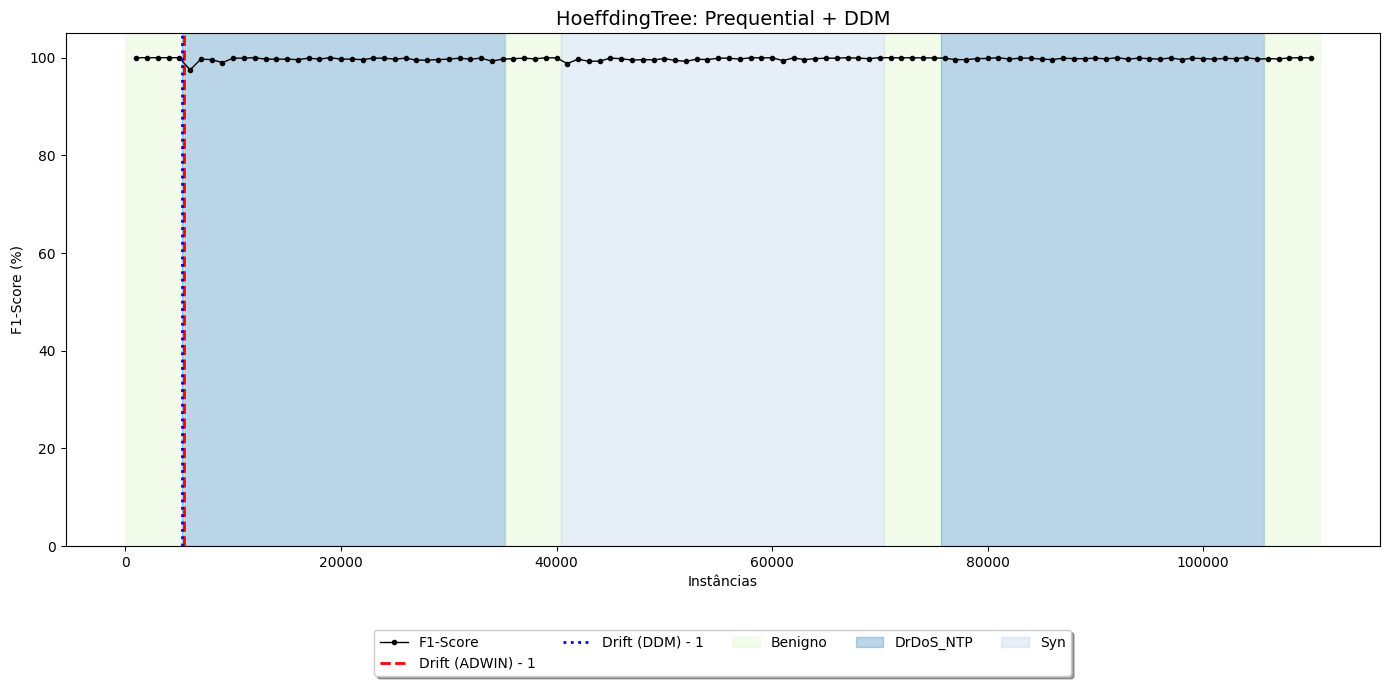

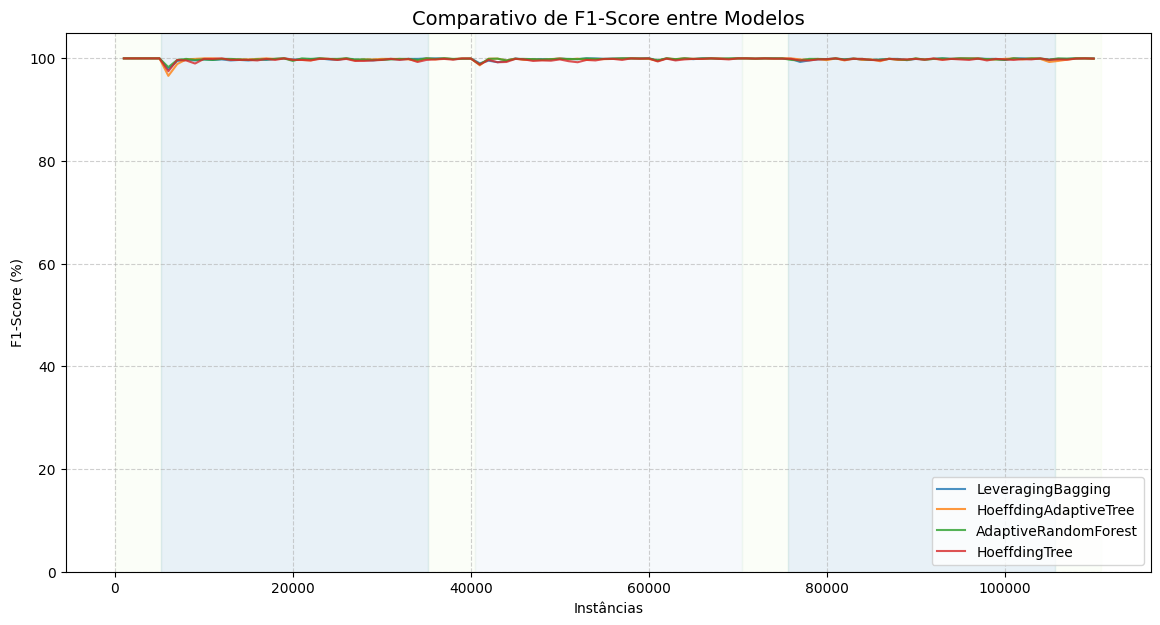

In [16]:
print("Sequencia do cenário B: [BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN]")
print("Y -> X -> Y")
print("Objetivo: Comparar a resposta dos modelos a um cenário de heterogeneidade similar ao cenário A, porém com a ordem dos ataques invertida. ")
print(f"Carregando Stream: {FILE_B}")
df_raw = pd.read_csv(FILE_B)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_D, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_D.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []
    models_to_test[m_name]["window_y_true"] = []      # NOVO: valores reais da janela
    models_to_test[m_name]["window_y_pred"] = []      # NOVO: predições da janela
    models_to_test[m_name]["results_f1score"] = []    # NOVO: trocar results_accuracy
    models_to_test[m_name]["window_errors"] = []      # Manter para drift detection

instance_count_history = []
count = 0

cenario_D.restart()

while cenario_D.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_D.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)

        # NOVO: Armazenar valores reais e predições para calcular F1
        state["window_y_true"].append(instance.y_index)
        state["window_y_pred"].append(pred_val)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            # Código substituído para cálculo de F1-Score (antes era acurácia)
            # mean_acc = 1.0 - np.mean(state["window_errors"])
            # state["results_accuracy"].append(mean_acc * 100)
            # state["window_errors"].clear()

            # Código novo para cálculo de F1-Score
            # Calcular F1-Score usando sklearn
            # average='binary' para classificação binária
            # ou 'weighted' para multi-classe
            f1 = f1_score(state["window_y_true"], 
                        state["window_y_pred"], 
                        average='weighted',
                        zero_division=0) * 100
            
            state["results_f1score"].append(f1)
            
            # Limpar as janelas
            state["window_y_true"].clear()
            state["window_y_pred"].clear()
            state["window_errors"].clear()

            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Código substituído para plotar acurácia
    # ax.plot(instance_count_history, state['results_accuracy'], 'o-',
    #         label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)

    # Código novo para plotar F1-Score
    ax.plot(instance_count_history, state['results_f1score'], 'o-',
        label='F1-Score', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    # ax.set_ylabel('Acurácia (%)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(14, 7))
# for model_name, state in models_to_test.items():
#     plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_f1score'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de F1-Score entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('F1-Score (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário C (F1 - Teste)

In [12]:
FILE_A = r'datasets\CICDDoS2019\Experimentos\Exp_A\stream_Heterogeneidade_A.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_A\metadata_Heterogeneidade_A.csv'
WINDOW_SIZE = 50
MAX_INSTANCES = 167828

Objetivo do cenário C: Analisar o mesmo stream do cenário A, porém agora a métrica de avaliação será o F1-Score.
Sequencia do cenário C (mesma do cenário A): [BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN]
Carregando Stream (mesma do cenário A): datasets\CICDDoS2019\Experimentos\Exp_A\stream_Heterogeneidade_A.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_NTP' 'Syn']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      Syn         5215  90.00%          124 0.000586
DrDoS_NTP        40430  89.00%          124 0.002800
      Syn        75645 100.00%           99 0.000000


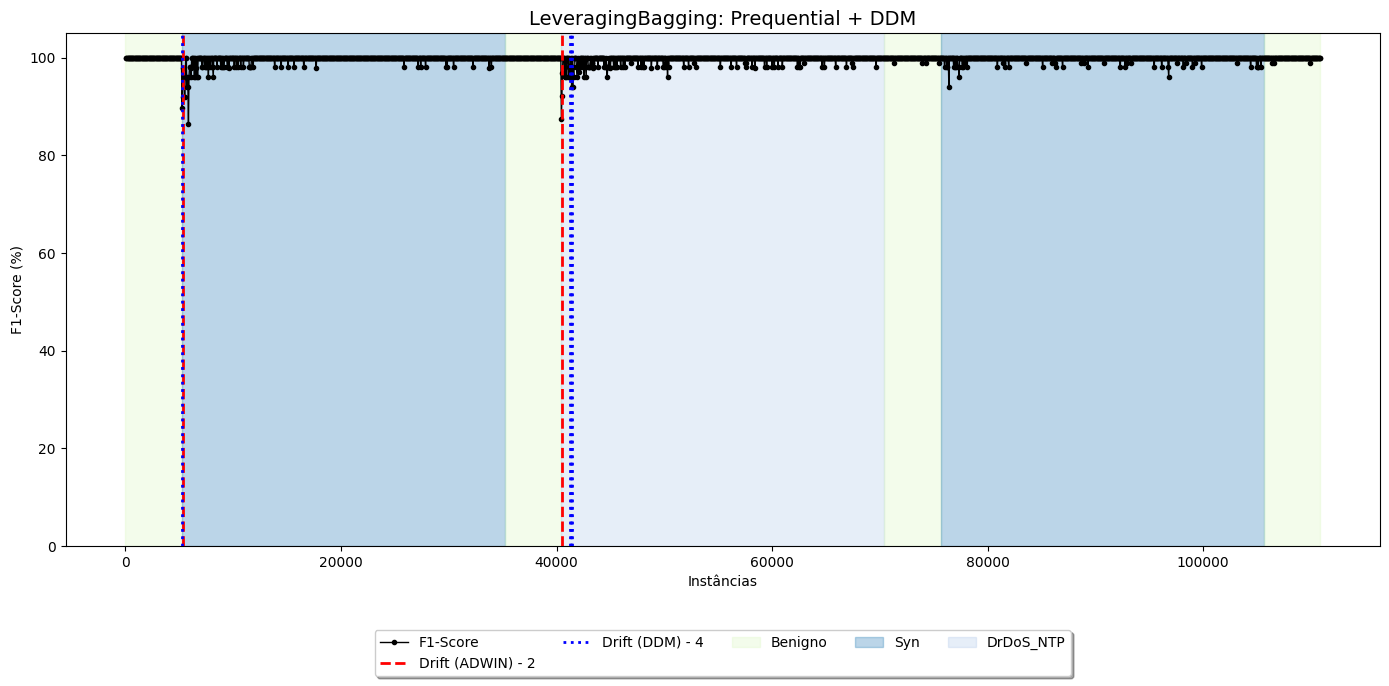

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
      Syn         5215  88.00%          145 -0.000000
DrDoS_NTP        40430  79.00%          208  0.003592
      Syn        75645  86.00%          213  0.002209


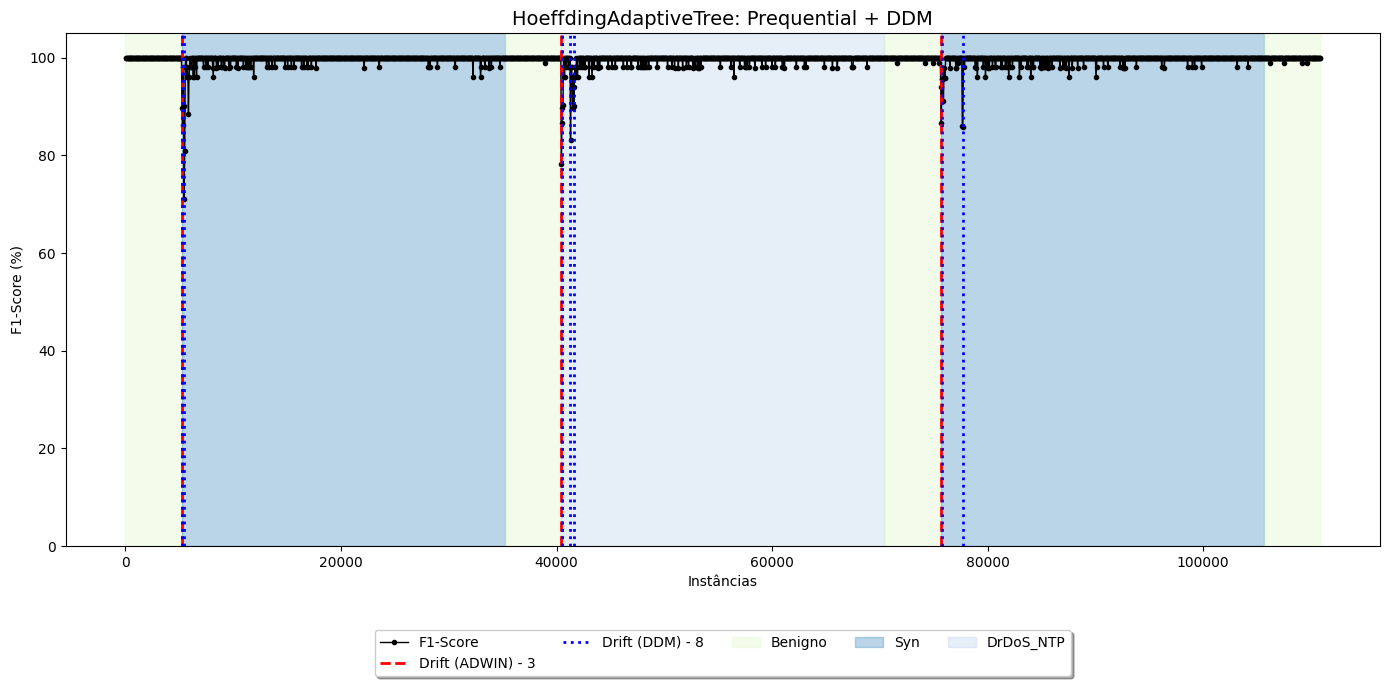

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
      Syn         5215  90.00%          132  0.000369
DrDoS_NTP        40430  92.00%          110  0.002548
      Syn        75645  99.00%           99 -0.000007


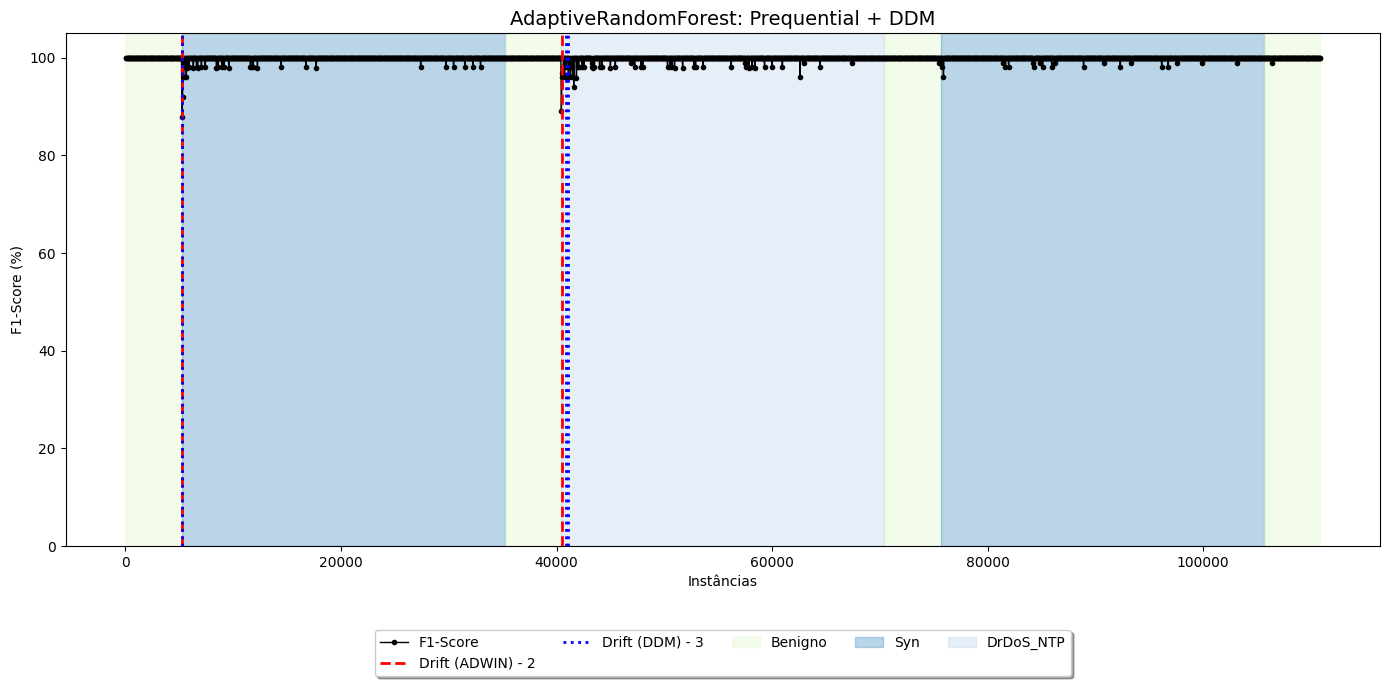

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      Syn         5215  93.00%          112 0.000947
DrDoS_NTP        40430  94.00%          100 0.001928
      Syn        75645  98.00%           99 0.001037


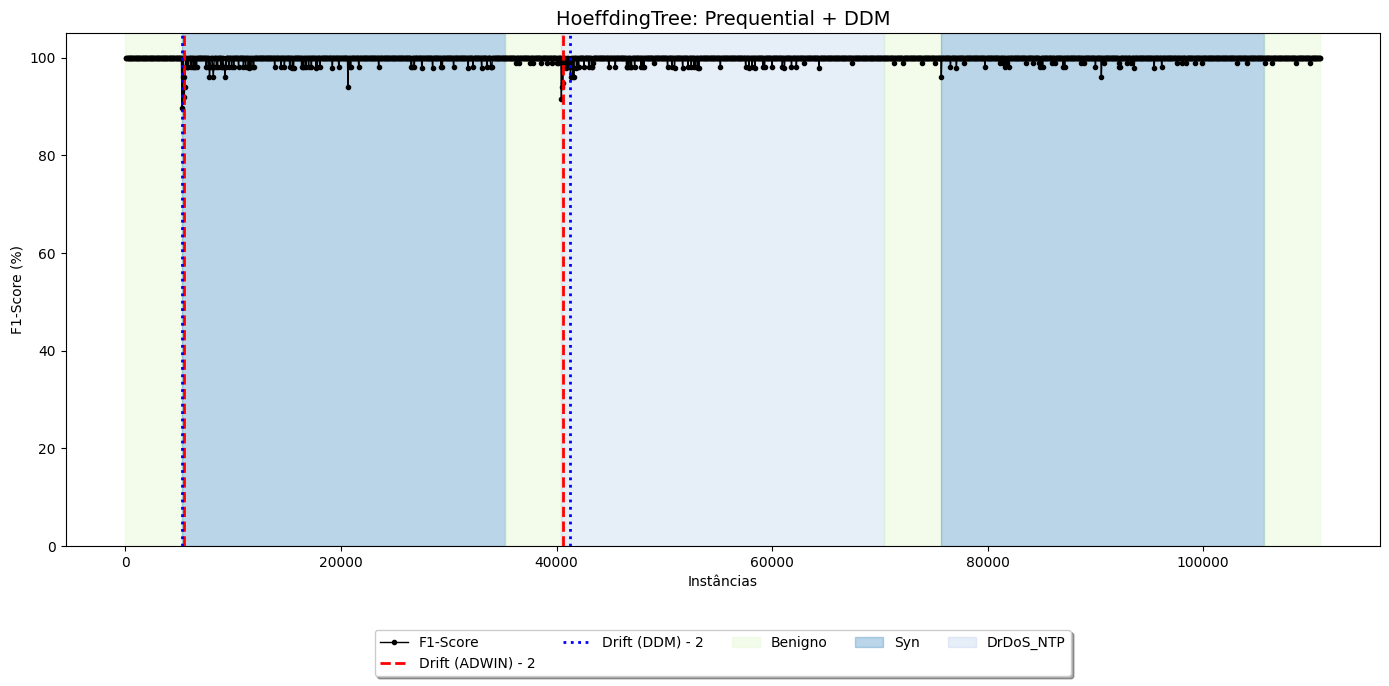

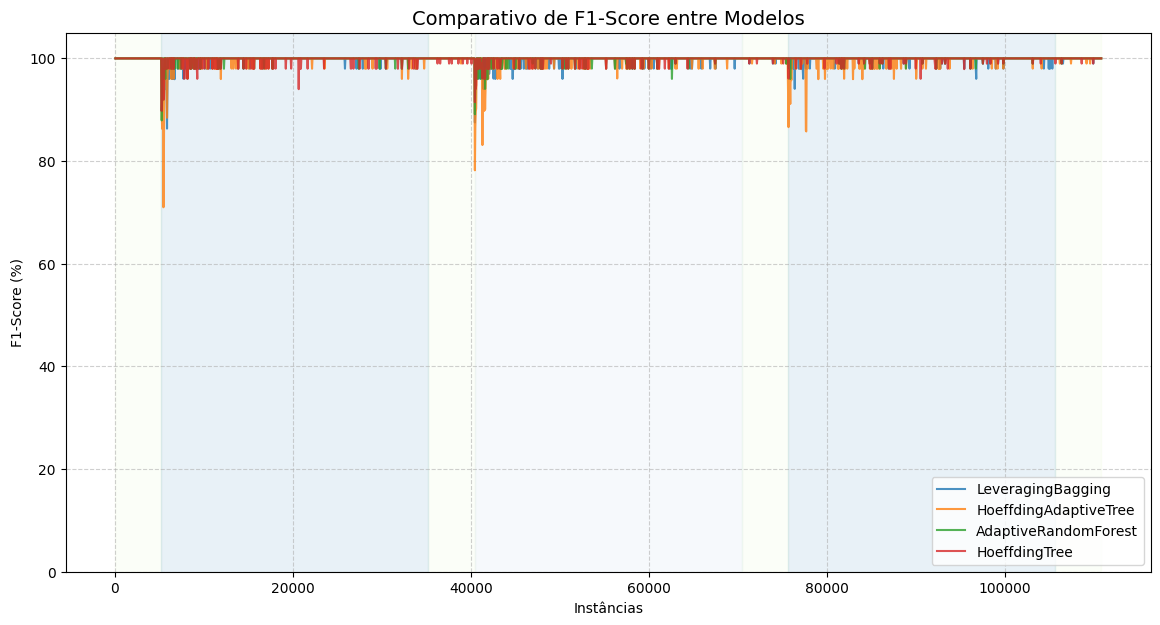

In [13]:
print("Objetivo do cenário C: Analisar o mesmo stream do cenário A, porém agora a métrica de avaliação será o F1-Score.")
print("Sequencia do cenário C (mesma do cenário A): [BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN]")
print(f"Carregando Stream (mesma do cenário A): {FILE_A}")
df_raw = pd.read_csv(FILE_A)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_C, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_C.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []
    models_to_test[m_name]["window_y_true"] = []      # NOVO: valores reais da janela
    models_to_test[m_name]["window_y_pred"] = []      # NOVO: predições da janela
    models_to_test[m_name]["results_f1score"] = []    # NOVO: trocar results_accuracy
    models_to_test[m_name]["window_errors"] = []      # Manter para drift detection

instance_count_history = []
count = 0

cenario_C.restart()

while cenario_C.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_C.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)

        # NOVO: Armazenar valores reais e predições para calcular F1
        state["window_y_true"].append(instance.y_index)
        state["window_y_pred"].append(pred_val)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            # Código substituído para cálculo de F1-Score (antes era acurácia)
            # mean_acc = 1.0 - np.mean(state["window_errors"])
            # state["results_accuracy"].append(mean_acc * 100)
            # state["window_errors"].clear()

            # Código novo para cálculo de F1-Score
            # Calcular F1-Score usando sklearn
            # average='binary' para classificação binária
            # ou 'weighted' para multi-classe
            f1 = f1_score(state["window_y_true"], 
                        state["window_y_pred"], 
                        average='weighted',
                        zero_division=0) * 100
            
            state["results_f1score"].append(f1)
            
            # Limpar as janelas
            state["window_y_true"].clear()
            state["window_y_pred"].clear()
            state["window_errors"].clear()

            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Código substituído para plotar acurácia
    # ax.plot(instance_count_history, state['results_accuracy'], 'o-',
    #         label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)

    # Código novo para plotar F1-Score
    ax.plot(instance_count_history, state['results_f1score'], 'o-',
        label='F1-Score', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    # ax.set_ylabel('Acurácia (%)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(14, 7))
# for model_name, state in models_to_test.items():
#     plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_f1score'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de F1-Score entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('F1-Score (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário D (ataques similares: A -> B -> A)

In [14]:
FILE_D = r'datasets\CICDDoS2019\Experimentos\Exp_D\stream_Homogeneidade_D.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_D\metadata_Homogeneidade_D.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Objetivo do cenário D: Analisar como os modelos se comportam diante de uma sequencia onde os dois ataques são muito similares (Ataque A e B)
Sequencia do cenário D: ['BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN']
A -> B -> A
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_D\stream_Homogeneidade_D.csv
Features: 80
Classes identificadas: ['BENIGN' 'DrDoS_SSDP' 'DrDoS_UDP']
======================= LeveragingBagging =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        19457  91.00%          119 0.001485
 DrDoS_UDP        68914  79.00%          122 0.005657
DrDoS_SSDP       118371  70.00%          171 0.005070


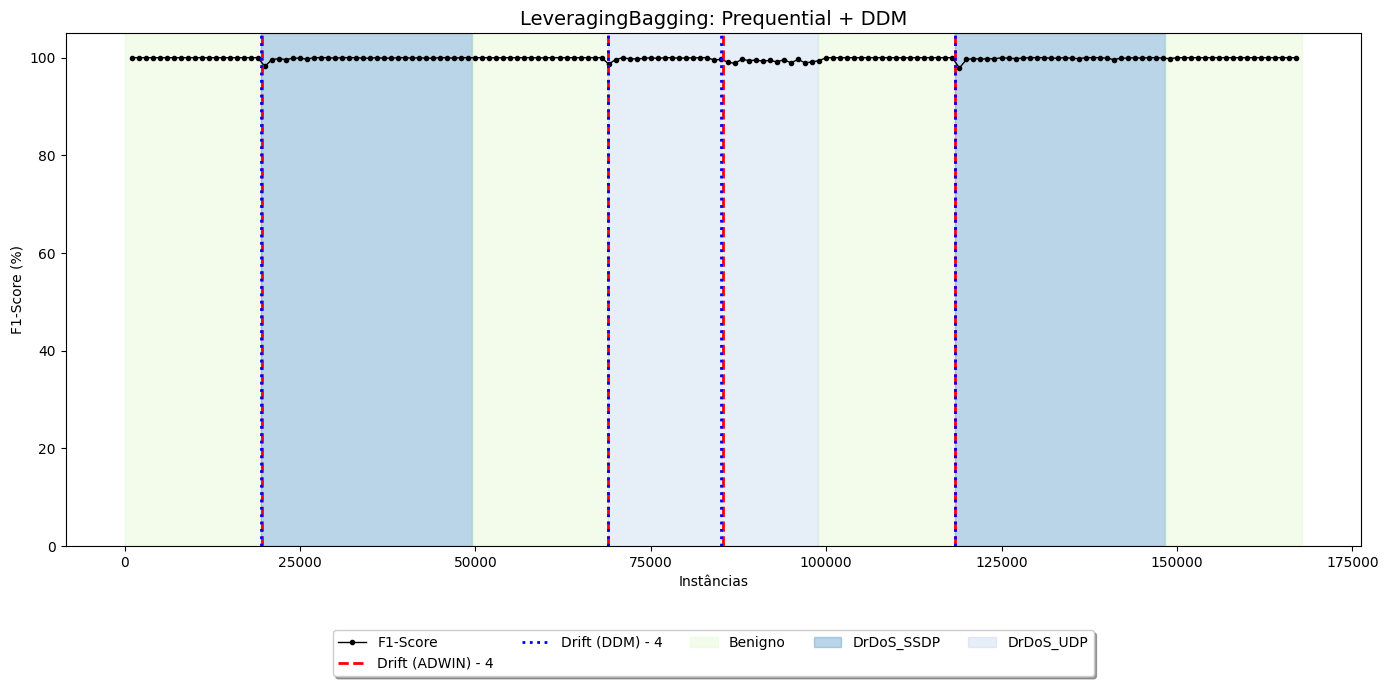

======================= HoeffdingAdaptiveTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        19457  92.00%          119 0.001428
 DrDoS_UDP        68914  76.00%          276 0.003572
DrDoS_SSDP       118371  39.00%          469 0.000424


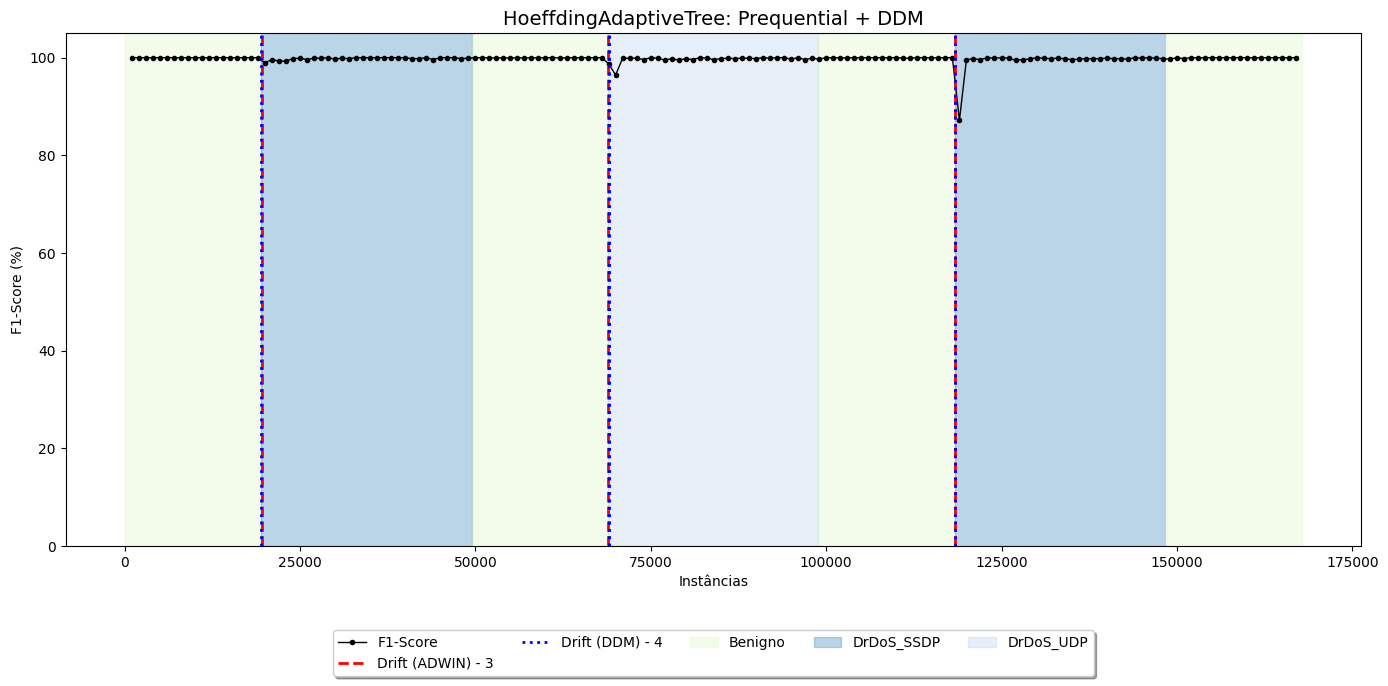

======================= AdaptiveRandomForest =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        19457  93.00%          104 0.001285
 DrDoS_UDP        68914  77.00%          126 0.005533
DrDoS_SSDP       118371  87.00%          112 0.005445


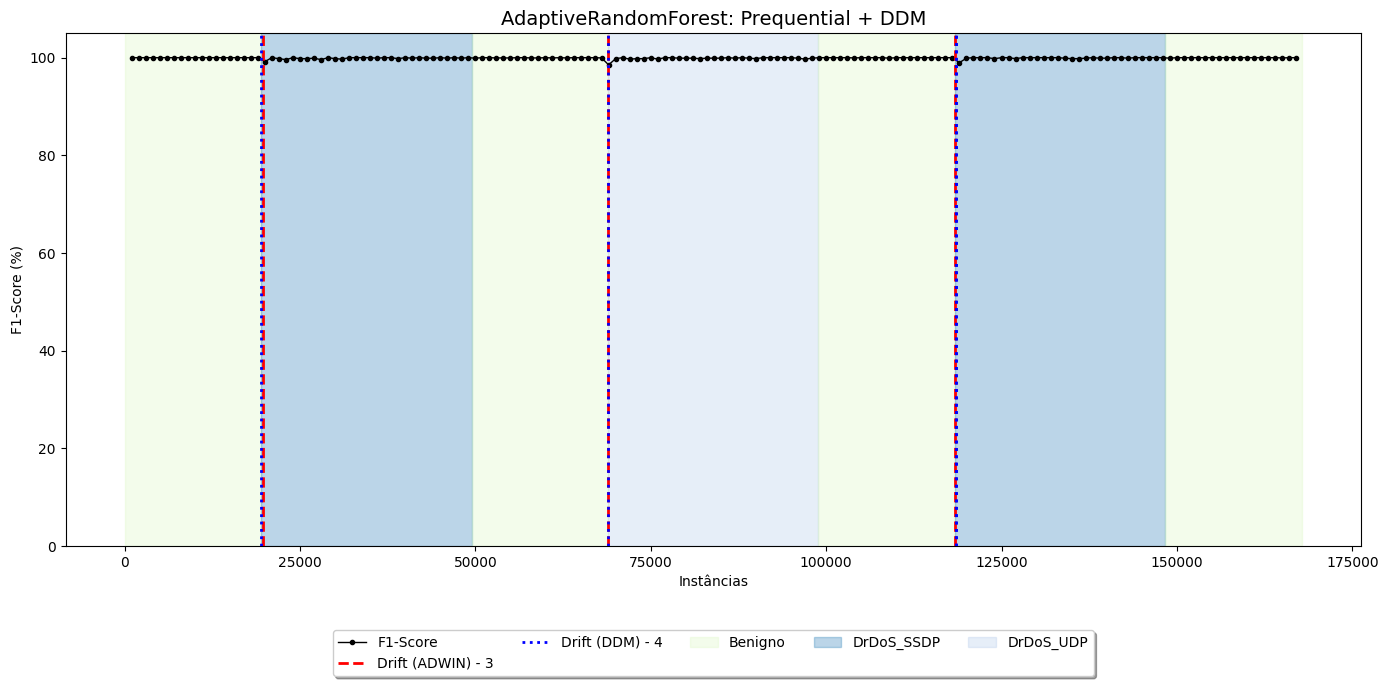

======================= HoeffdingTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
DrDoS_SSDP        19457  95.00%           99  0.001722
 DrDoS_UDP        68914  48.00%          349  0.001741
DrDoS_SSDP       118371  38.00%          551 -0.000093


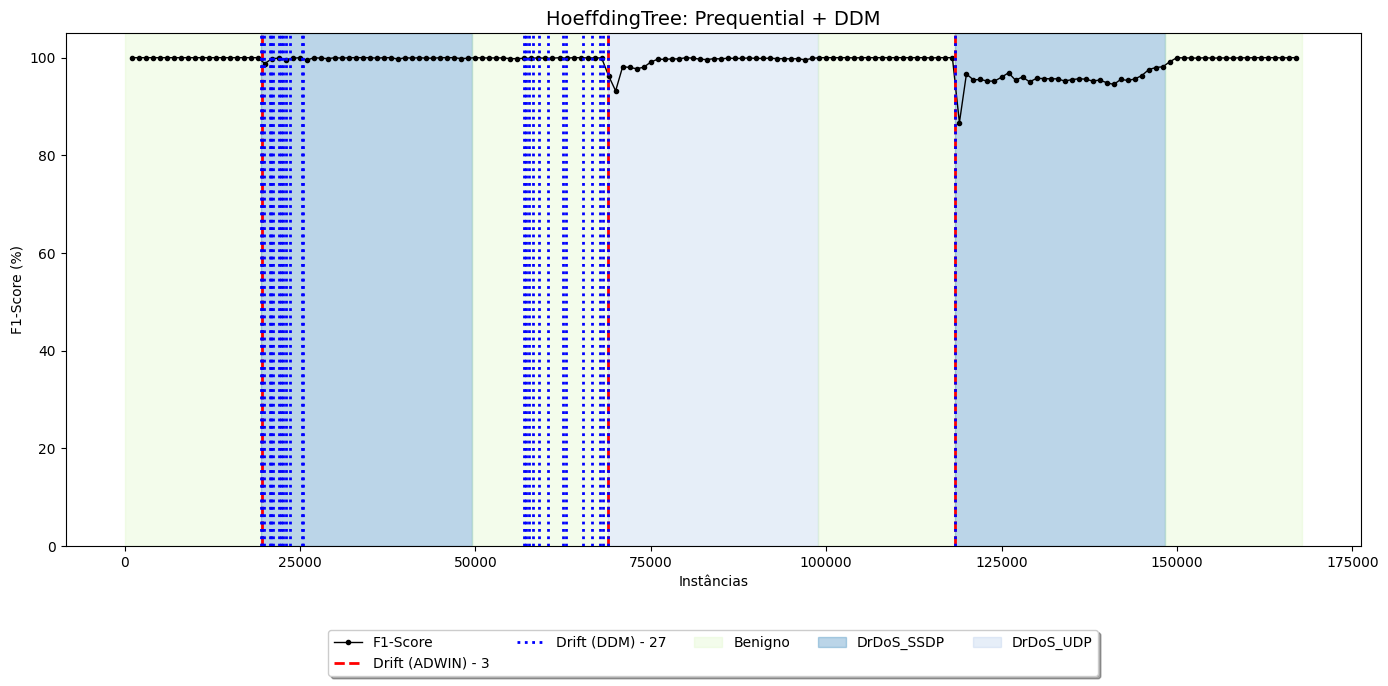

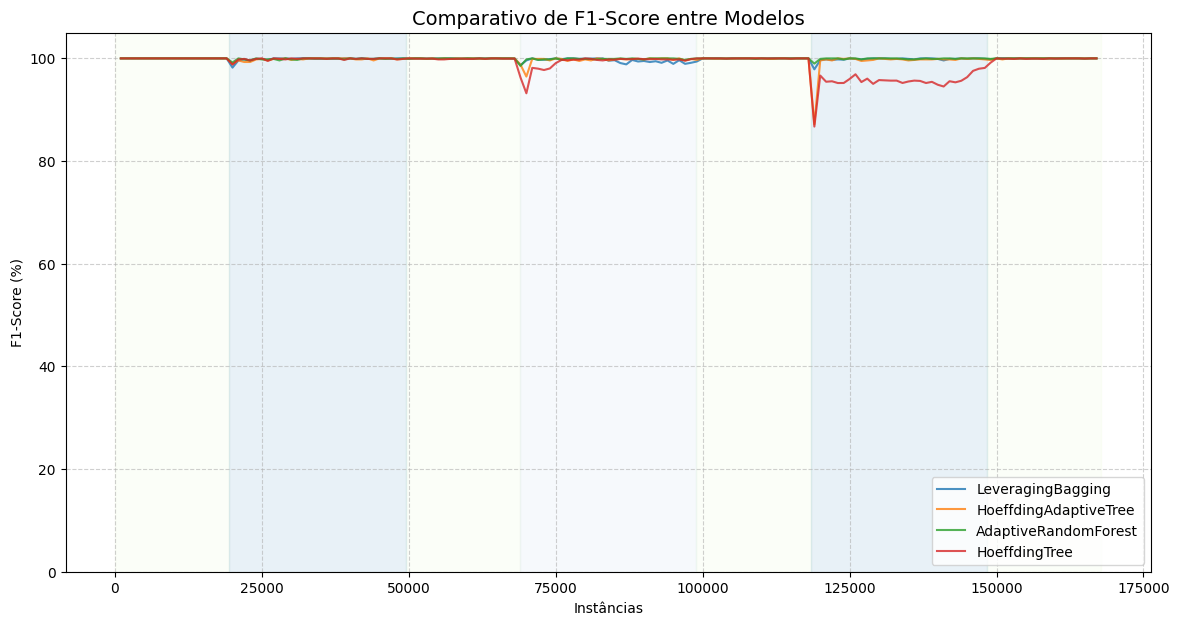

In [16]:
print("Objetivo do cenário D: Analisar como os modelos se comportam diante de uma sequencia onde os dois ataques são muito similares (Ataque A e B)")
print("Sequencia do cenário D: ['BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN']")
print("A -> B -> A")
print(f"Carregando Stream: {FILE_D}")
df_raw = pd.read_csv(FILE_D)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_D, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_D.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []
    models_to_test[m_name]["window_y_true"] = []      # NOVO: valores reais da janela
    models_to_test[m_name]["window_y_pred"] = []      # NOVO: predições da janela
    models_to_test[m_name]["results_f1score"] = []    # NOVO: trocar results_accuracy
    models_to_test[m_name]["window_errors"] = []      # Manter para drift detection

instance_count_history = []
count = 0

cenario_D.restart()

while cenario_D.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_D.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)

        # NOVO: Armazenar valores reais e predições para calcular F1
        state["window_y_true"].append(instance.y_index)
        state["window_y_pred"].append(pred_val)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            # Código substituído para cálculo de F1-Score (antes era acurácia)
            # mean_acc = 1.0 - np.mean(state["window_errors"])
            # state["results_accuracy"].append(mean_acc * 100)
            # state["window_errors"].clear()

            # Código novo para cálculo de F1-Score
            # Calcular F1-Score usando sklearn
            # average='binary' para classificação binária
            # ou 'weighted' para multi-classe
            f1 = f1_score(state["window_y_true"], 
                        state["window_y_pred"], 
                        average='weighted',
                        zero_division=0) * 100
            
            state["results_f1score"].append(f1)
            
            # Limpar as janelas
            state["window_y_true"].clear()
            state["window_y_pred"].clear()
            state["window_errors"].clear()

            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Código substituído para plotar acurácia
    # ax.plot(instance_count_history, state['results_accuracy'], 'o-',
    #         label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)

    # Código novo para plotar F1-Score
    ax.plot(instance_count_history, state['results_f1score'], 'o-',
        label='F1-Score', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    # ax.set_ylabel('Acurácia (%)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(14, 7))
# for model_name, state in models_to_test.items():
#     plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_f1score'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de F1-Score entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('F1-Score (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário E (ataques similares: A -> A -> B)

In [21]:
FILE_E = r'datasets\CICDDoS2019\Experimentos\Exp_E\stream_homogeneidade_E.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_E\metadata_homogeneidade_E.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Objetivo do cenário E: Analisar como os modelos se comportam diante de uma sequencia onde os dois ataques são muito similares (Ataque A e B)
Sequencia do cenário E: ['BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN']
A -> A -> B
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_E\stream_homogeneidade_E.csv
Features: 80
Classes identificadas: ['BENIGN' 'DrDoS_SSDP' 'DrDoS_UDP']
======================= LeveragingBagging =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        19457  91.00%          119 0.001485
DrDoS_SSDP        68914 100.00%           99 0.000000
 DrDoS_UDP       118371  67.00%          213 0.004255


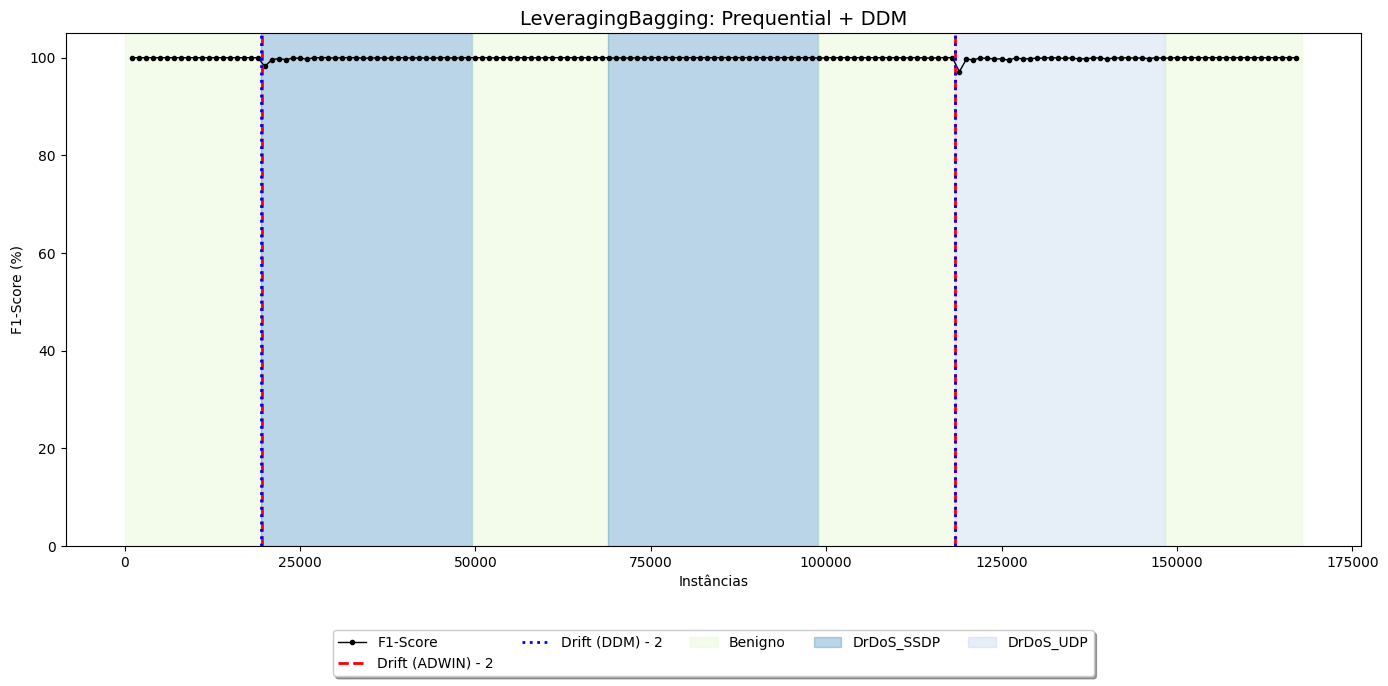

======================= HoeffdingAdaptiveTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        19457  92.00%          119 0.001428
DrDoS_SSDP        68914 100.00%           99 0.000000
 DrDoS_UDP       118371  81.00%          148 0.005845


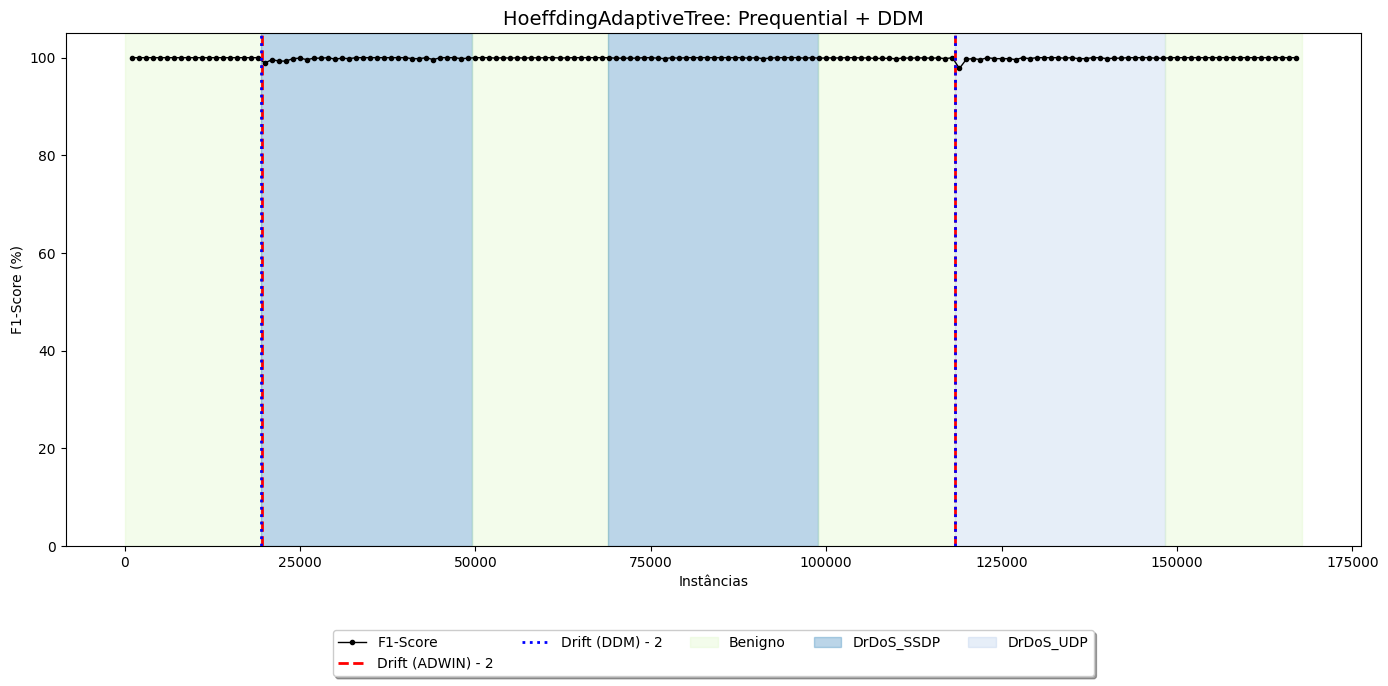

======================= AdaptiveRandomForest =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        19457  93.00%          104 0.001285
DrDoS_SSDP        68914 100.00%           99 0.000000
 DrDoS_UDP       118371  82.00%          119 0.006183


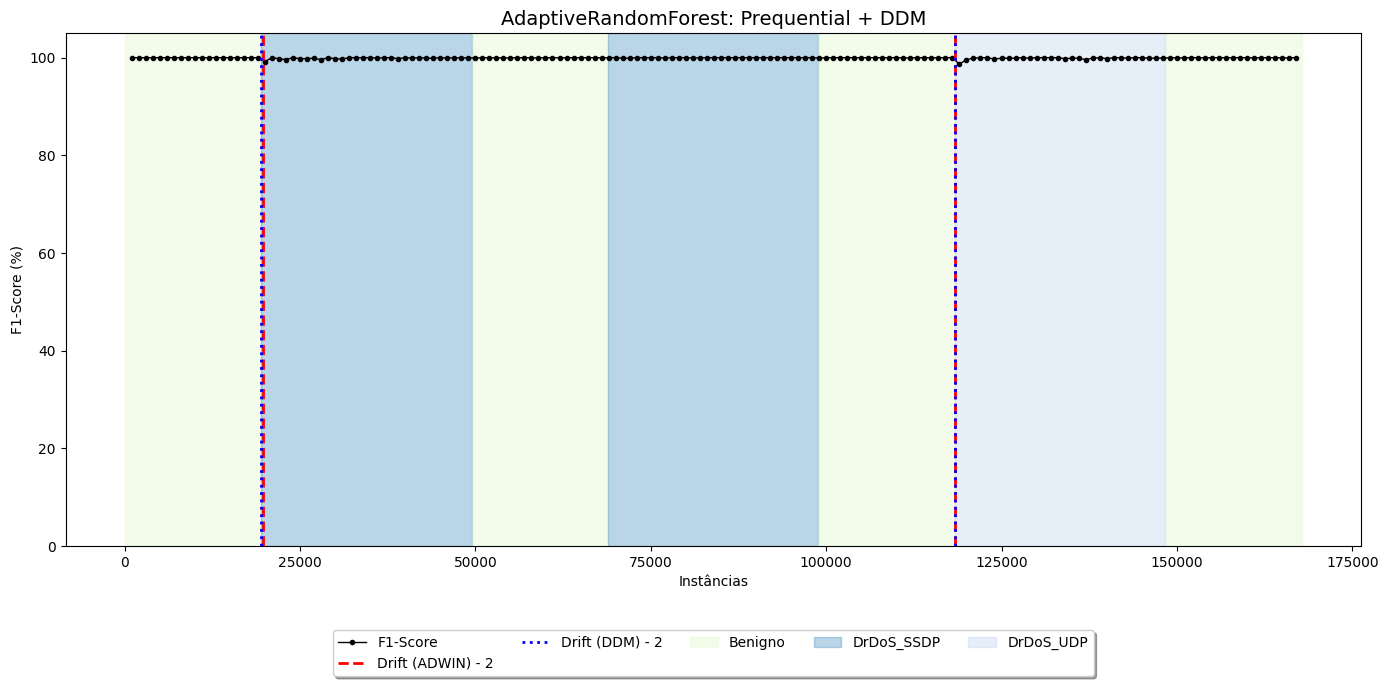

======================= HoeffdingTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        19457  95.00%           99 0.001722
DrDoS_SSDP        68914 100.00%           99 0.000000
 DrDoS_UDP       118371  52.00%          272 0.002810


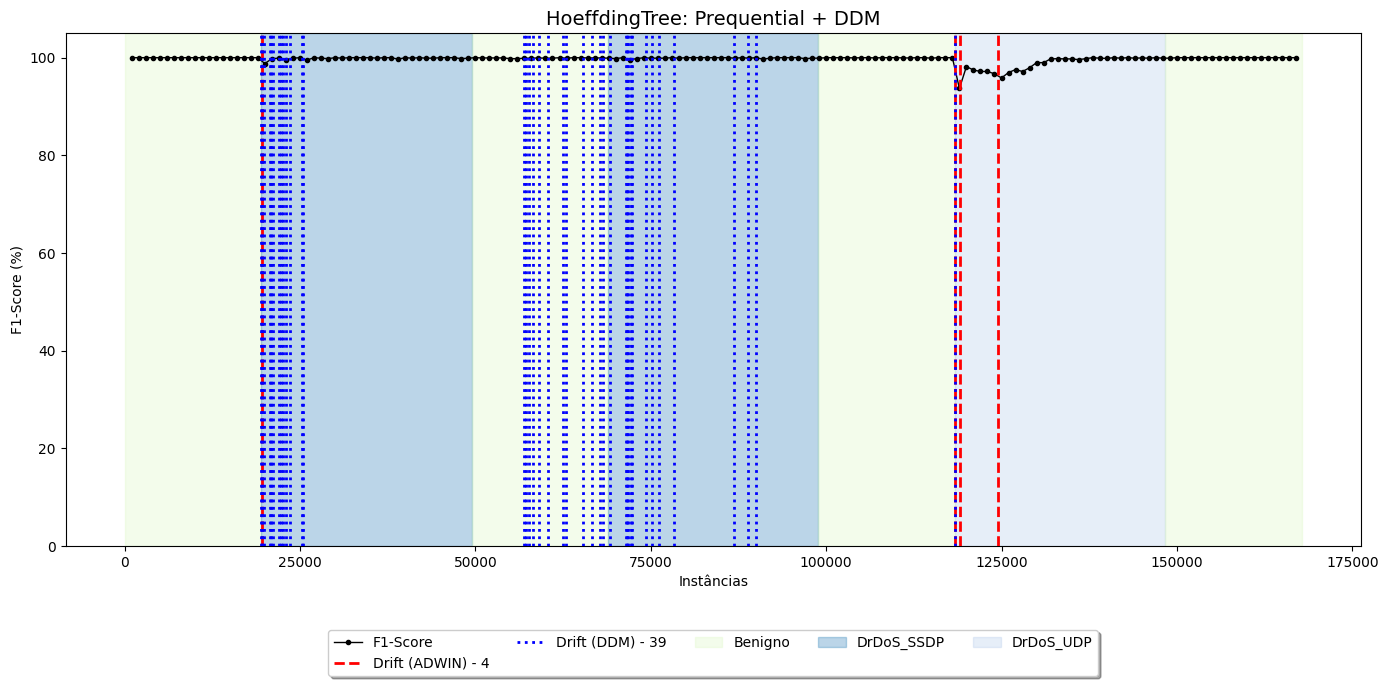

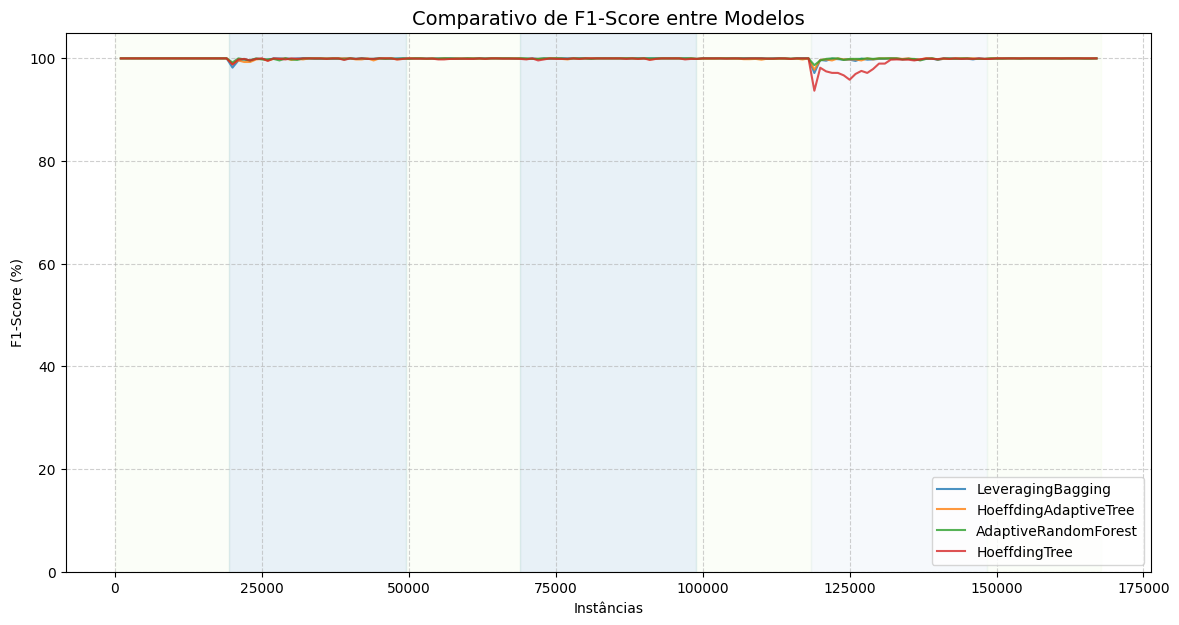

In [22]:
print("Objetivo do cenário E: Analisar como os modelos se comportam diante de uma sequencia onde os dois ataques são muito similares (Ataque A e B)")
print("Sequencia do cenário E: ['BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN']")
print("A -> A -> B")
print(f"Carregando Stream: {FILE_E}")
df_raw = pd.read_csv(FILE_E)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_E, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_E.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []
    models_to_test[m_name]["window_y_true"] = []      # NOVO: valores reais da janela
    models_to_test[m_name]["window_y_pred"] = []      # NOVO: predições da janela
    models_to_test[m_name]["results_f1score"] = []    # NOVO: trocar results_accuracy
    models_to_test[m_name]["window_errors"] = []      # Manter para drift detection

instance_count_history = []
count = 0

cenario_E.restart()

while cenario_E.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_E.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)

        # NOVO: Armazenar valores reais e predições para calcular F1
        state["window_y_true"].append(instance.y_index)
        state["window_y_pred"].append(pred_val)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            # Código substituído para cálculo de F1-Score (antes era acurácia)
            # mean_acc = 1.0 - np.mean(state["window_errors"])
            # state["results_accuracy"].append(mean_acc * 100)
            # state["window_errors"].clear()

            # Código novo para cálculo de F1-Score
            # Calcular F1-Score usando sklearn
            # average='binary' para classificação binária
            # ou 'weighted' para multi-classe
            f1 = f1_score(state["window_y_true"], 
                        state["window_y_pred"], 
                        average='weighted',
                        zero_division=0) * 100
            
            state["results_f1score"].append(f1)
            
            # Limpar as janelas
            state["window_y_true"].clear()
            state["window_y_pred"].clear()
            state["window_errors"].clear()

            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Código substituído para plotar acurácia
    # ax.plot(instance_count_history, state['results_accuracy'], 'o-',
    #         label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)

    # Código novo para plotar F1-Score
    ax.plot(instance_count_history, state['results_f1score'], 'o-',
        label='F1-Score', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    # ax.set_ylabel('Acurácia (%)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(14, 7))
# for model_name, state in models_to_test.items():
#     plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_f1score'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de F1-Score entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('F1-Score (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário F (Ataques semelhantes: B -> A -> B)

In [7]:
FILE_F = r'datasets\CICDDoS2019\Experimentos\Exp_F\stream_homogeneidade_F.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_F\metadata_homogeneidade_F.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Objetivo do cenário F: Comparar como os modelos se comportam diante de uma sequencia, que agora, começa com o ataque B ao inves do ataque A.
Qual é a precisão do modelo ao identificar o ataque B, sem antes ter passado pelo ataque A?
Sequencia do cenário F: ['BENIGN', 'DrDoS_UDP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN']
B -> A -> B
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_F\stream_homogeneidade_F.csv
Features: 80
Classes identificadas: ['BENIGN' 'DrDoS_SSDP' 'DrDoS_UDP']
======================= LeveragingBagging =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
 DrDoS_UDP        19457  92.00%          105 0.002274
DrDoS_SSDP        68914  75.00%          127 0.005642
 DrDoS_UDP       118371  69.00%          262 0.004761


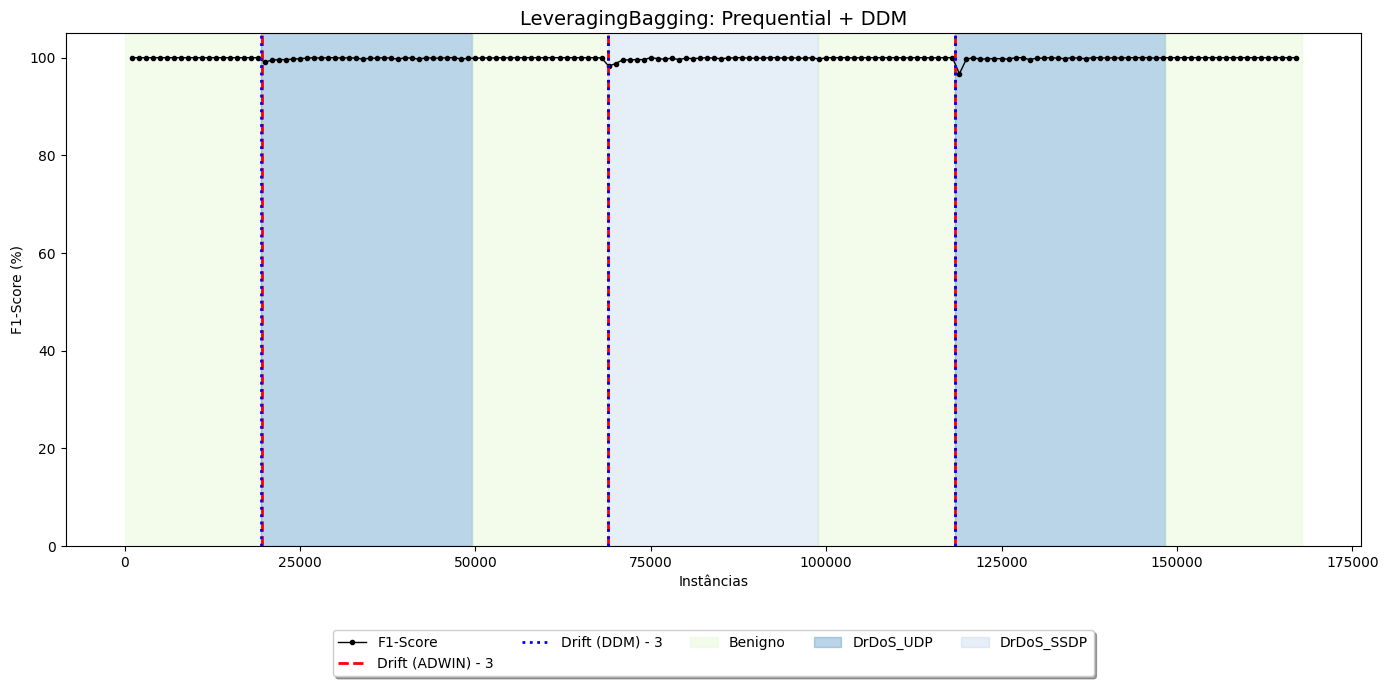

======================= HoeffdingAdaptiveTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
 DrDoS_UDP        19457  90.00%          140 0.002101
DrDoS_SSDP        68914  76.00%          127 0.005916
 DrDoS_UDP       118371  60.00%          458 0.003154


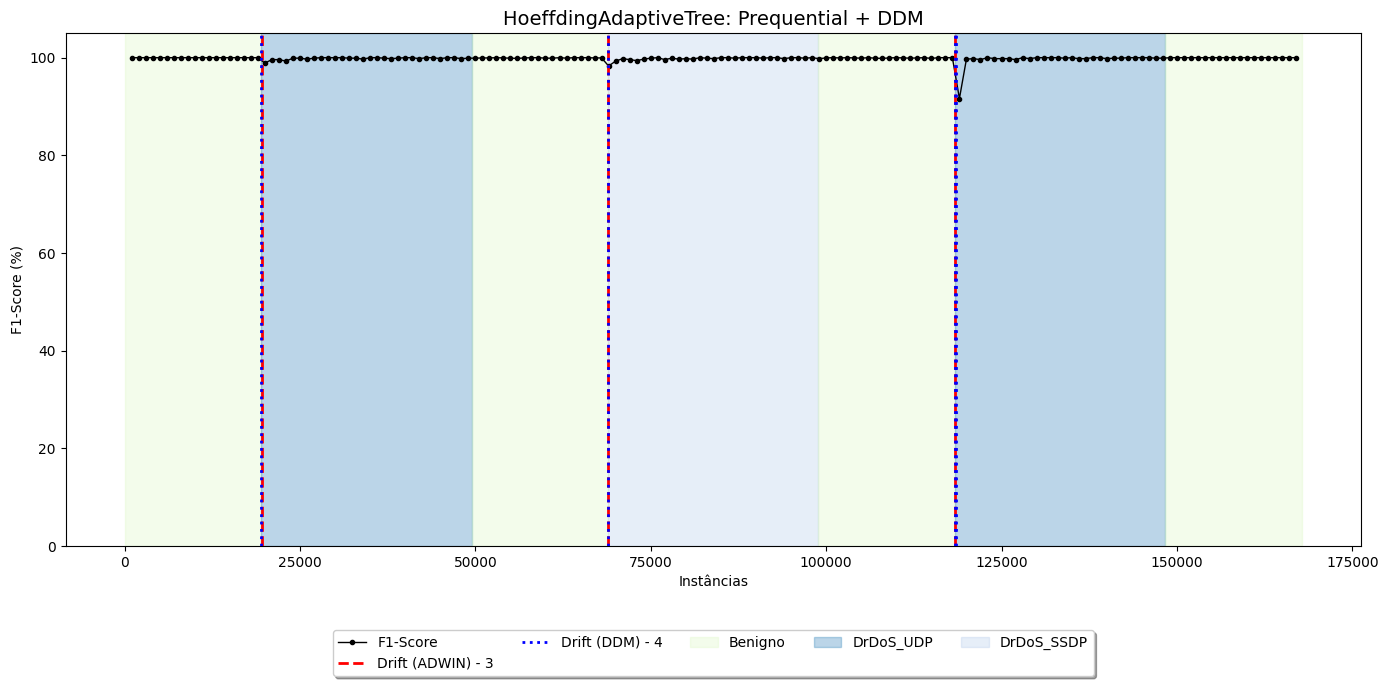

======================= AdaptiveRandomForest =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
 DrDoS_UDP        19457  90.00%          110 0.002892
DrDoS_SSDP        68914  80.00%          127 0.005419
 DrDoS_UDP       118371  86.00%          113 0.005376


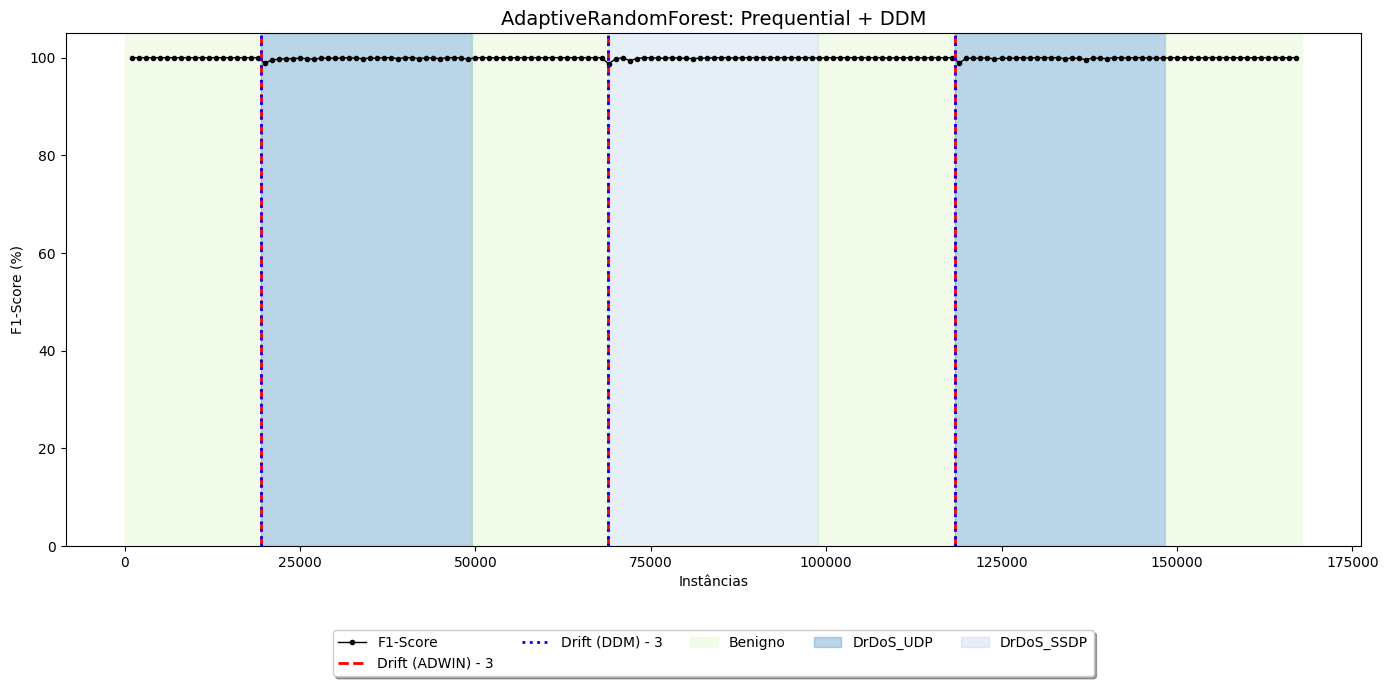

======================= HoeffdingTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
 DrDoS_UDP        19457  93.00%          104 0.002432
DrDoS_SSDP        68914  37.00%          272 0.000216
 DrDoS_UDP       118371  54.00%          432 0.002855


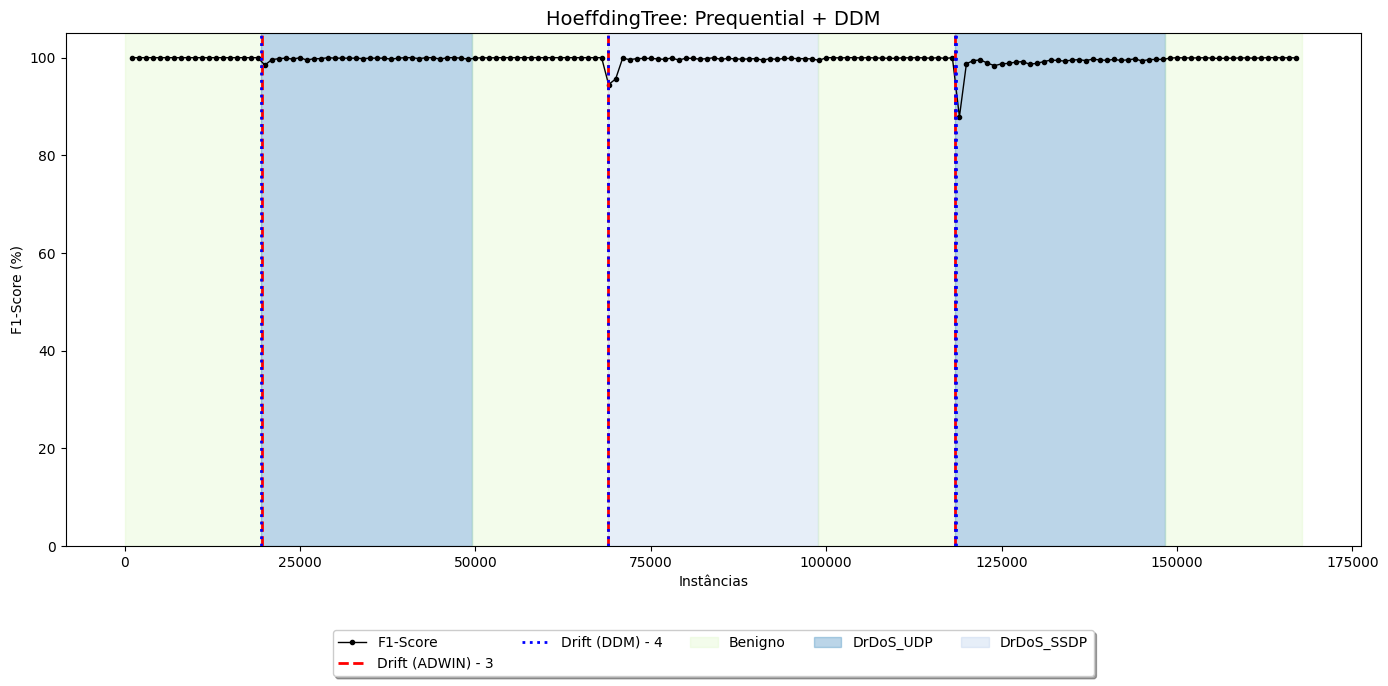

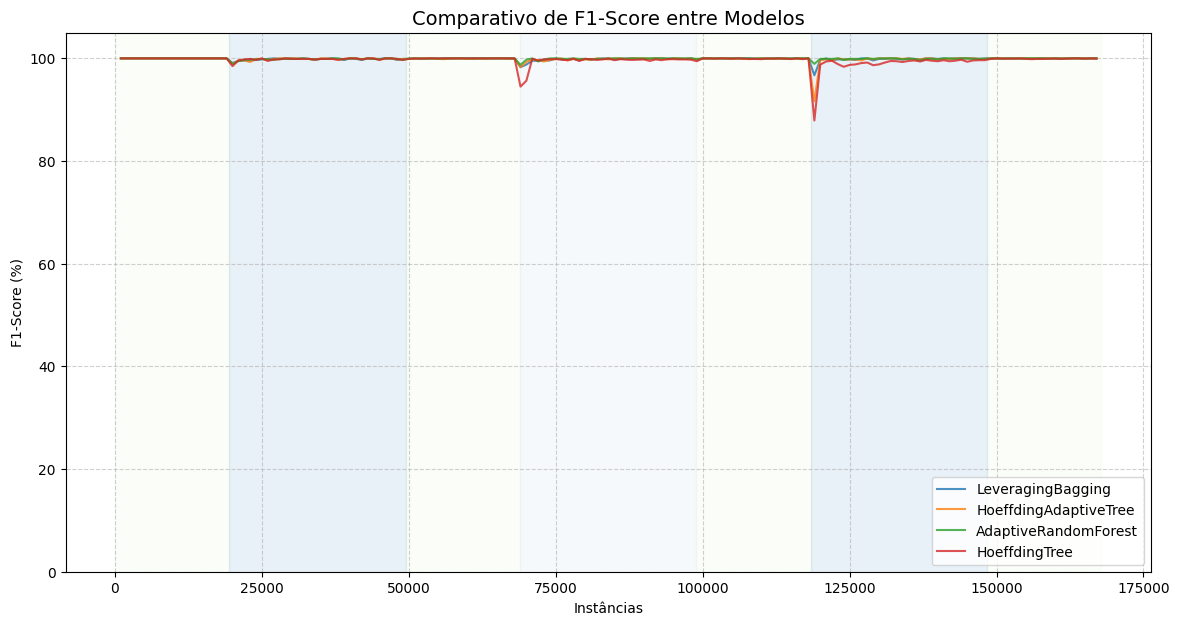

In [8]:
print("Objetivo do cenário F: Comparar como os modelos se comportam diante de uma sequencia, que agora, começa com o ataque B ao inves do ataque A.\nQual é a precisão do modelo ao identificar o ataque B, sem antes ter passado pelo ataque A?")
print("Sequencia do cenário F: ['BENIGN', 'DrDoS_UDP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN']")
print("B -> A -> B")
print(f"Carregando Stream: {FILE_F}")
df_raw = pd.read_csv(FILE_F)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_F, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_F.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []
    models_to_test[m_name]["window_y_true"] = []      # NOVO: valores reais da janela
    models_to_test[m_name]["window_y_pred"] = []      # NOVO: predições da janela
    models_to_test[m_name]["results_f1score"] = []    # NOVO: trocar results_accuracy
    models_to_test[m_name]["window_errors"] = []      # Manter para drift detection

instance_count_history = []
count = 0

cenario_F.restart()

while cenario_F.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_F.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)

        # NOVO: Armazenar valores reais e predições para calcular F1
        state["window_y_true"].append(instance.y_index)
        state["window_y_pred"].append(pred_val)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            # Código substituído para cálculo de F1-Score (antes era acurácia)
            # mean_acc = 1.0 - np.mean(state["window_errors"])
            # state["results_accuracy"].append(mean_acc * 100)
            # state["window_errors"].clear()

            # Código novo para cálculo de F1-Score
            # Calcular F1-Score usando sklearn
            # average='binary' para classificação binária
            # ou 'weighted' para multi-classe
            f1 = f1_score(state["window_y_true"], 
                        state["window_y_pred"], 
                        average='weighted',
                        zero_division=0) * 100
            
            state["results_f1score"].append(f1)
            
            # Limpar as janelas
            state["window_y_true"].clear()
            state["window_y_pred"].clear()
            state["window_errors"].clear()

            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Código substituído para plotar acurácia
    # ax.plot(instance_count_history, state['results_accuracy'], 'o-',
    #         label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)

    # Código novo para plotar F1-Score
    ax.plot(instance_count_history, state['results_f1score'], 'o-',
        label='F1-Score', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    # ax.set_ylabel('Acurácia (%)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(14, 7))
# for model_name, state in models_to_test.items():
#     plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_f1score'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de F1-Score entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('F1-Score (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário G (Ataques semelhantes: A -> B -> C -> A)

In [9]:
FILE_E = r'datasets\CICDDoS2019\Experimentos\Exp_G\stream_homogeneidade_G.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_G\metadata_homogeneidade_G.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Aqui vamos lidar também com um ataque C, que é semelhante aos ataques A e B, mas difere um pouco mais.
Objetivo do cenário G: Analisar como os modelos se comportam diante de uma sequencia onde os três ataques são muito similares (Ataque A, B e C)
Sequencia do cenário G: ['BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN', 'TFTP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN']
A -> B -> C -> A
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_G\stream_homogeneidade_G.csv
Features: 80
Classes identificadas: ['BENIGN' 'DrDoS_SSDP' 'DrDoS_UDP' 'TFTP']
======================= LeveragingBagging =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        13165  93.00%          108 0.001633
 DrDoS_UDP        56330  73.00%          171 0.005008
      TFTP        99495  86.00%          119 0.004959
DrDoS_SSDP       142660  90.00%          114 0.002994


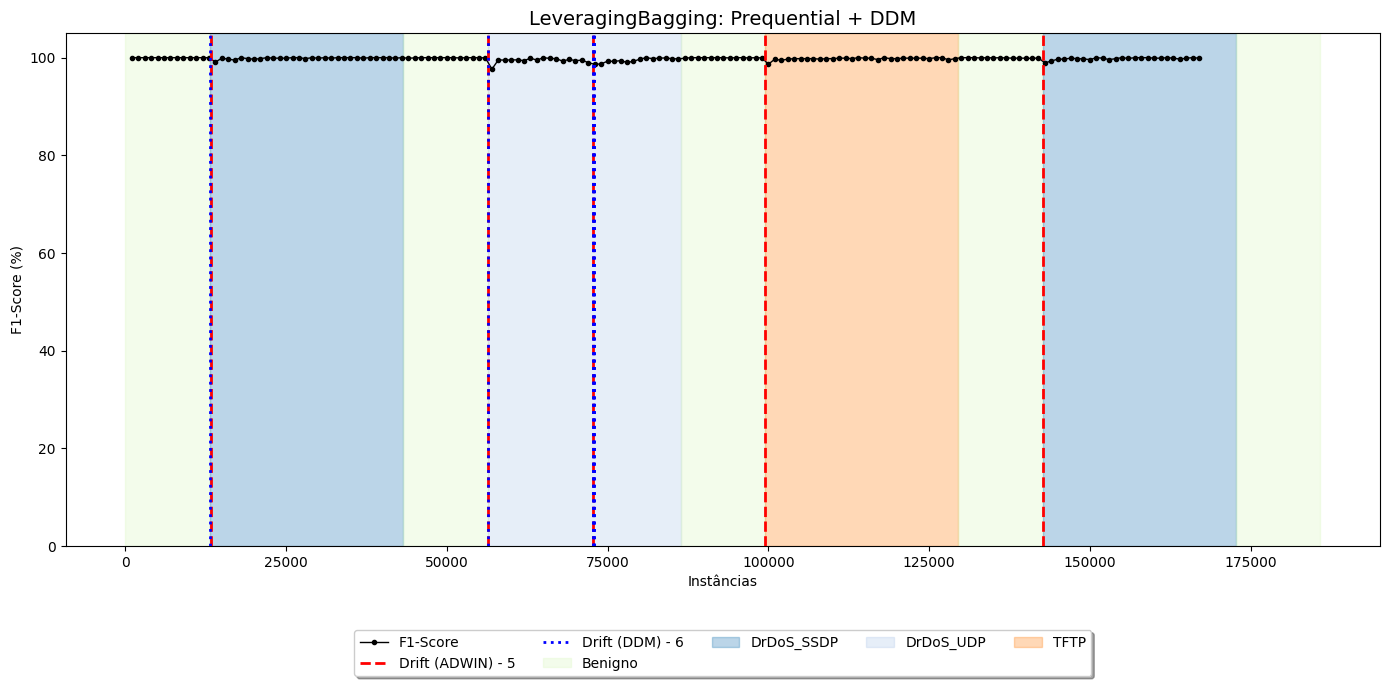

======================= HoeffdingAdaptiveTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        13165  90.00%          133 0.000918
 DrDoS_UDP        56330  49.00%          479 0.001605
      TFTP        99495  91.00%          106 0.002692
DrDoS_SSDP       142660  90.00%          107 0.004779


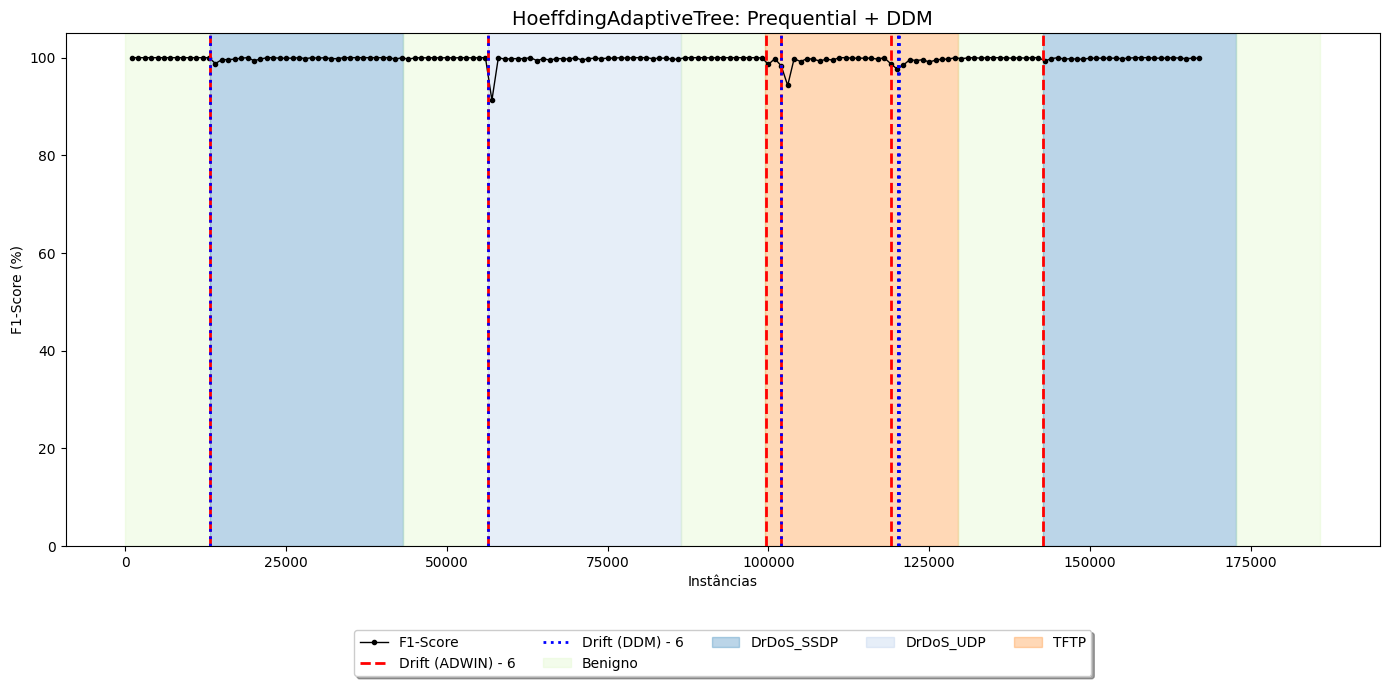

======================= AdaptiveRandomForest =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        13165  92.00%          108 0.001100
 DrDoS_UDP        56330  77.00%          126 0.005533
      TFTP        99495  85.00%          115 0.005237
DrDoS_SSDP       142660  89.00%          110 0.004782


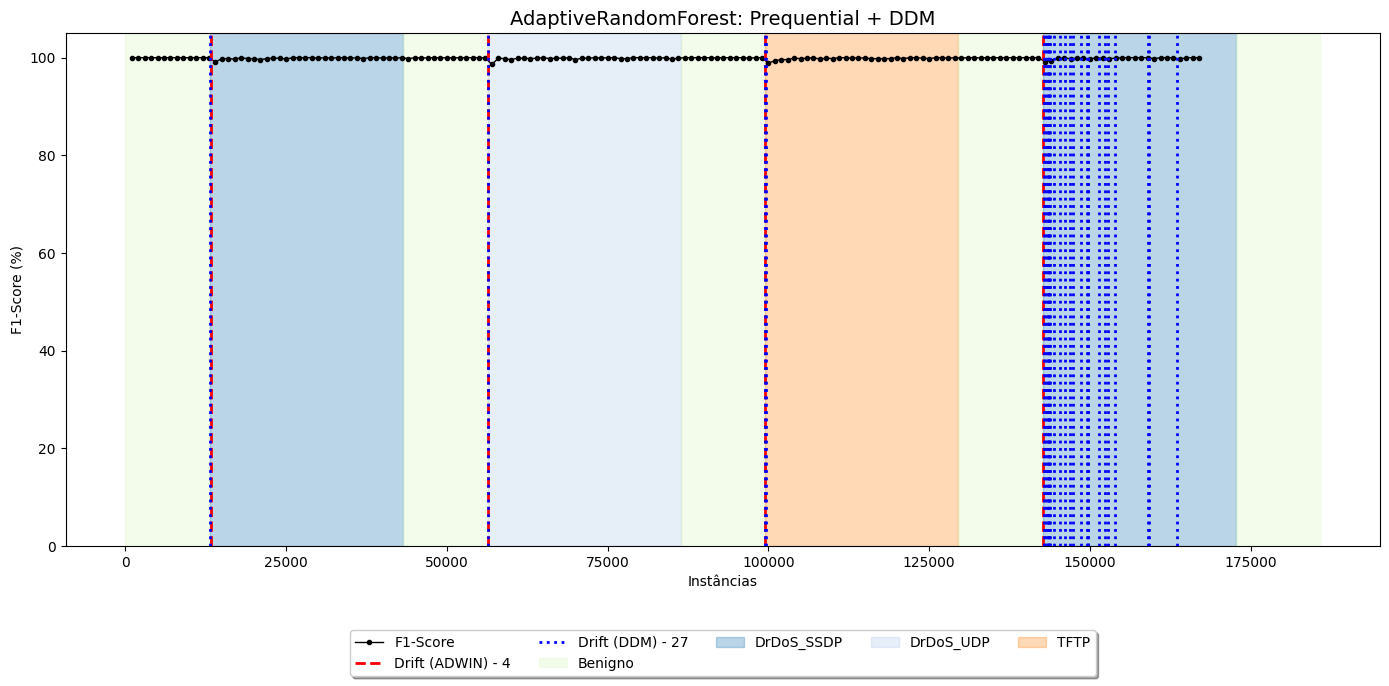

======================= HoeffdingTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_SSDP        13165  91.00%          119 0.001065
 DrDoS_UDP        56330  51.00%          424 0.001888
      TFTP        99495  74.00%          342 0.002728
DrDoS_SSDP       142660  57.00%          264 0.001728


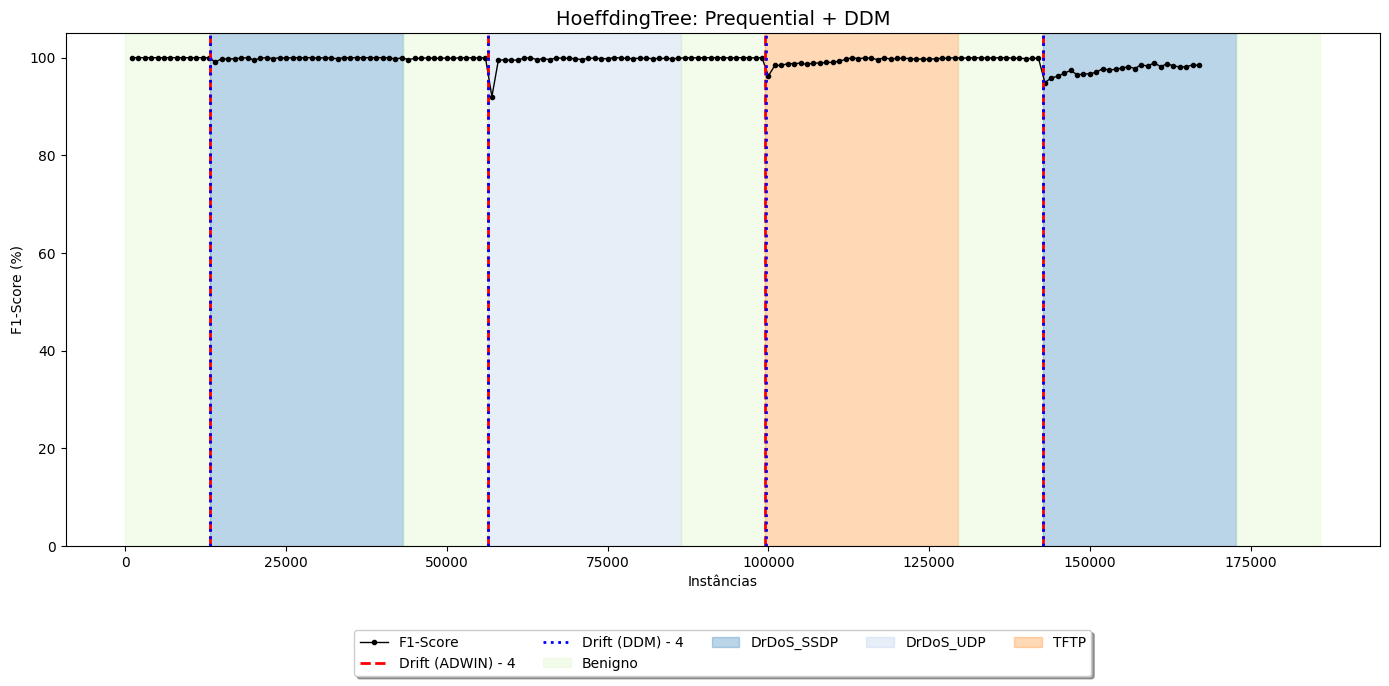

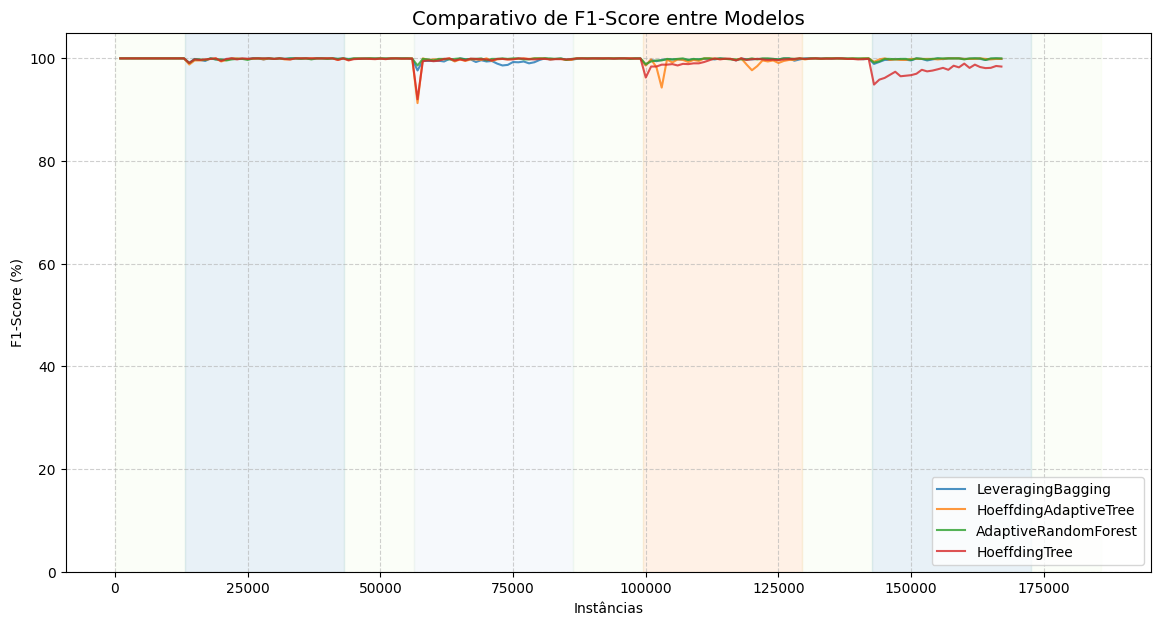

In [11]:
print("Aqui vamos lidar também com um ataque C, que é semelhante aos ataques A e B, mas difere um pouco mais.")
print("Objetivo do cenário G: Analisar como os modelos se comportam diante de uma sequencia onde os três ataques são muito similares (Ataque A, B e C)")
print("Sequencia do cenário G: ['BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN', 'TFTP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN']")
print("A -> B -> C -> A")
print(f"Carregando Stream: {FILE_E}")
df_raw = pd.read_csv(FILE_E)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_E, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_E.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []
    models_to_test[m_name]["window_y_true"] = []      # NOVO: valores reais da janela
    models_to_test[m_name]["window_y_pred"] = []      # NOVO: predições da janela
    models_to_test[m_name]["results_f1score"] = []    # NOVO: trocar results_accuracy
    models_to_test[m_name]["window_errors"] = []      # Manter para drift detection

instance_count_history = []
count = 0

cenario_E.restart()

while cenario_E.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_E.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)

        # NOVO: Armazenar valores reais e predições para calcular F1
        state["window_y_true"].append(instance.y_index)
        state["window_y_pred"].append(pred_val)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            # Código substituído para cálculo de F1-Score (antes era acurácia)
            # mean_acc = 1.0 - np.mean(state["window_errors"])
            # state["results_accuracy"].append(mean_acc * 100)
            # state["window_errors"].clear()

            # Código novo para cálculo de F1-Score
            # Calcular F1-Score usando sklearn
            # average='binary' para classificação binária
            # ou 'weighted' para multi-classe
            f1 = f1_score(state["window_y_true"], 
                        state["window_y_pred"], 
                        average='weighted',
                        zero_division=0) * 100
            
            state["results_f1score"].append(f1)
            
            # Limpar as janelas
            state["window_y_true"].clear()
            state["window_y_pred"].clear()
            state["window_errors"].clear()

            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Código substituído para plotar acurácia
    # ax.plot(instance_count_history, state['results_accuracy'], 'o-',
    #         label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)

    # Código novo para plotar F1-Score
    ax.plot(instance_count_history, state['results_f1score'], 'o-',
        label='F1-Score', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    # ax.set_ylabel('Acurácia (%)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(14, 7))
# for model_name, state in models_to_test.items():
#     plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_f1score'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de F1-Score entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('F1-Score (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário H (Ataques semelhantes: C -> B -> A -> C)

In [12]:
FILE_E = r'datasets\CICDDoS2019\Experimentos\Exp_H\stream_Homogeneidade_H.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_H\metadata_Homogeneidade_H.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Objetivo do cenário H: Analisar como os modelos se comportam diante de uma sequencia onde os três ataques são muito similares (Ataque A, B e C), mas com uma ordem diferente do cenário G.
Sequencia do cenário H: ['BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN']
C -> B -> A -> C
Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_H\stream_Homogeneidade_H.csv
Features: 80
Classes identificadas: ['BENIGN' 'DrDoS_SSDP' 'DrDoS_UDP' 'TFTP']
======================= LeveragingBagging =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      TFTP        13165  93.00%          104 0.001684
 DrDoS_UDP        56330  79.00%          191 0.001835
DrDoS_SSDP        99495  57.00%          230 0.003120
      TFTP       142660  84.00%          129 0.002417


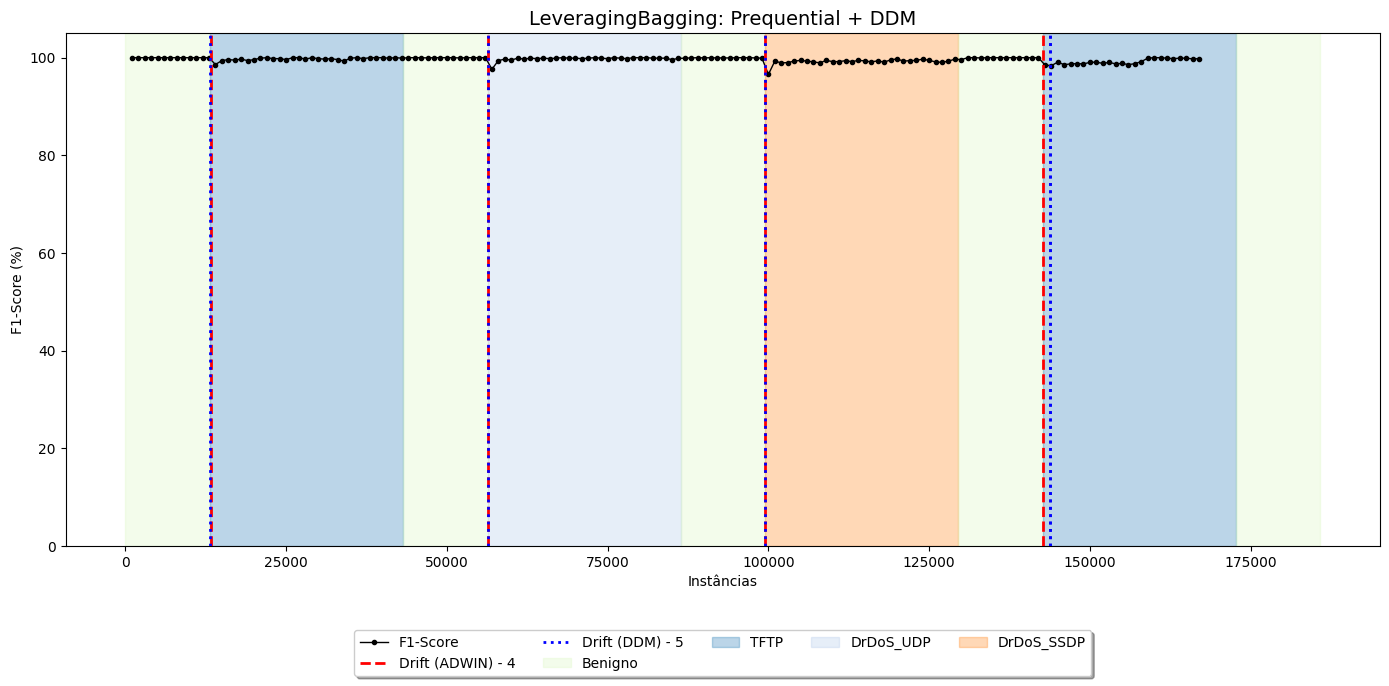

======================= HoeffdingAdaptiveTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      TFTP        13165  88.00%          137 0.000917
 DrDoS_UDP        56330  84.00%          190 0.001010
DrDoS_SSDP        99495  38.00%          460 0.000361
      TFTP       142660  41.00%          207 0.000438


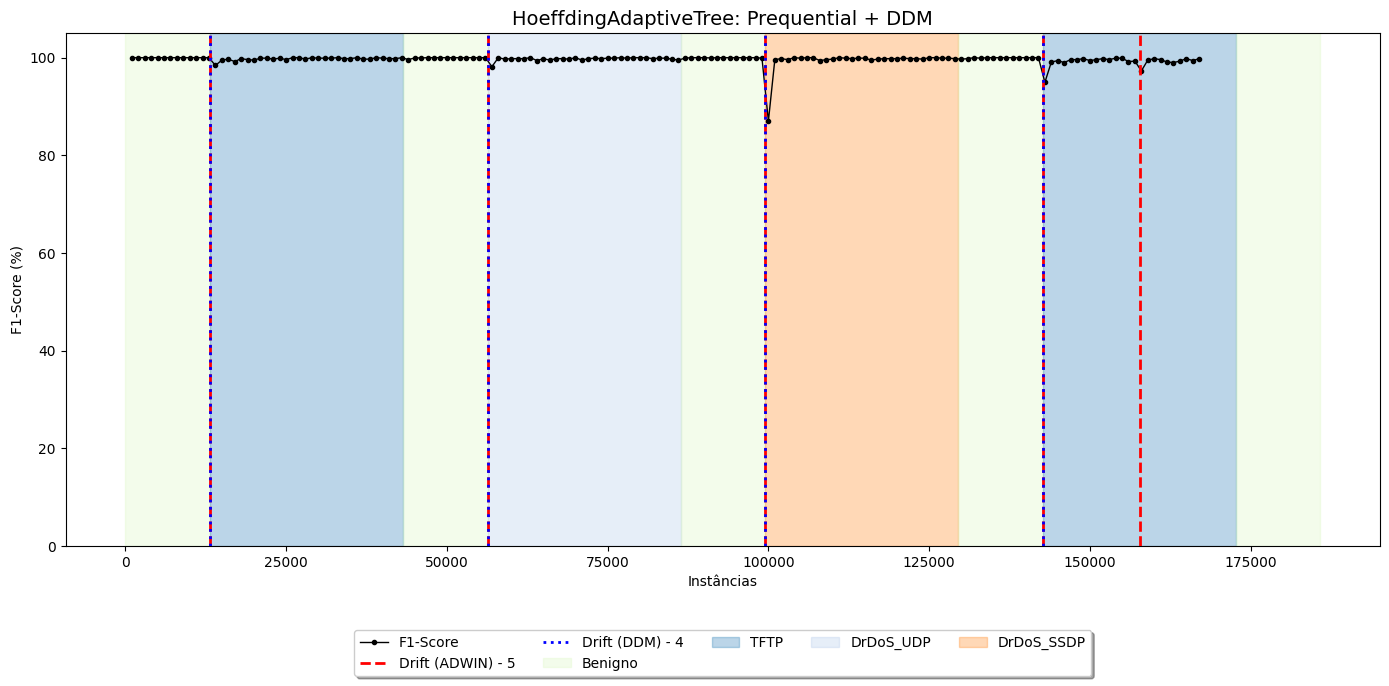

======================= AdaptiveRandomForest =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      TFTP        13165  90.00%          131 0.001651
 DrDoS_UDP        56330  86.00%          117 0.003758
DrDoS_SSDP        99495  87.00%          112 0.005690
      TFTP       142660  88.00%          110 0.005404


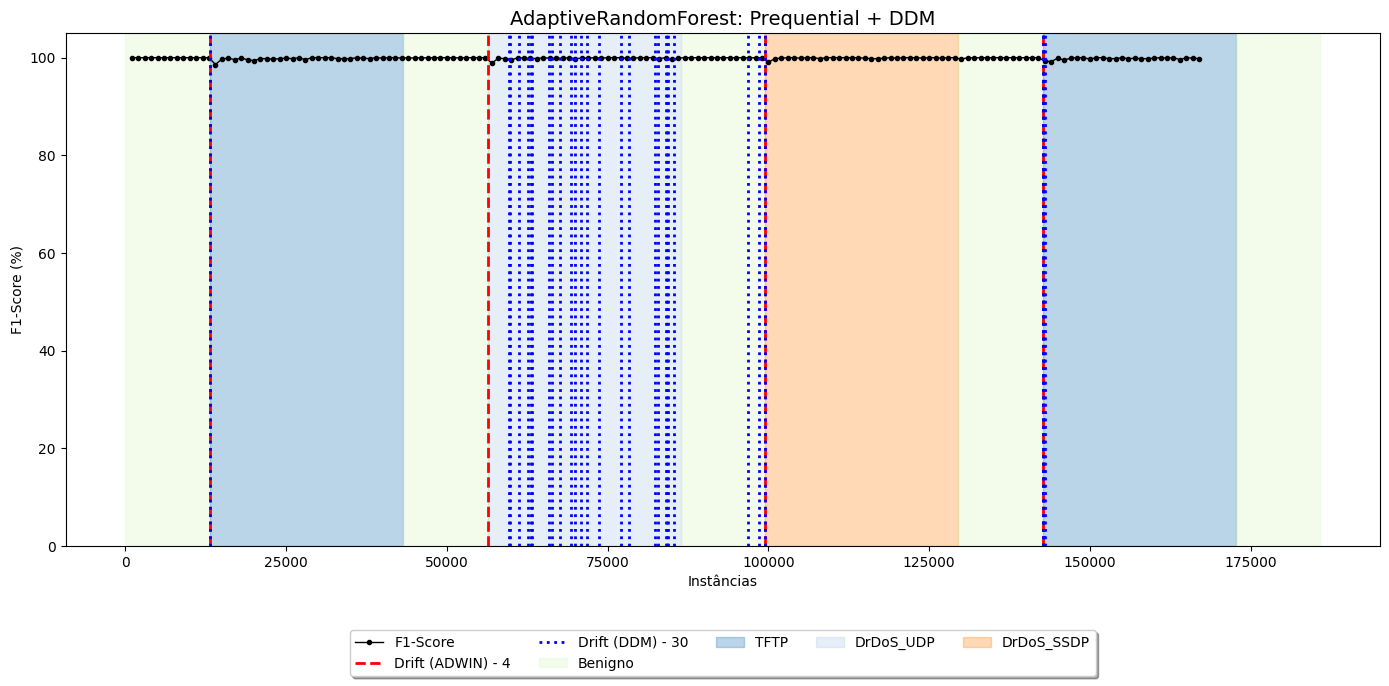

======================= HoeffdingTree =======================
    Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      TFTP        13165  89.00%          137 0.001017
 DrDoS_UDP        56330  91.00%          110 0.001438
DrDoS_SSDP        99495  51.00%          324 0.002766
      TFTP       142660  66.00%          944 0.001839


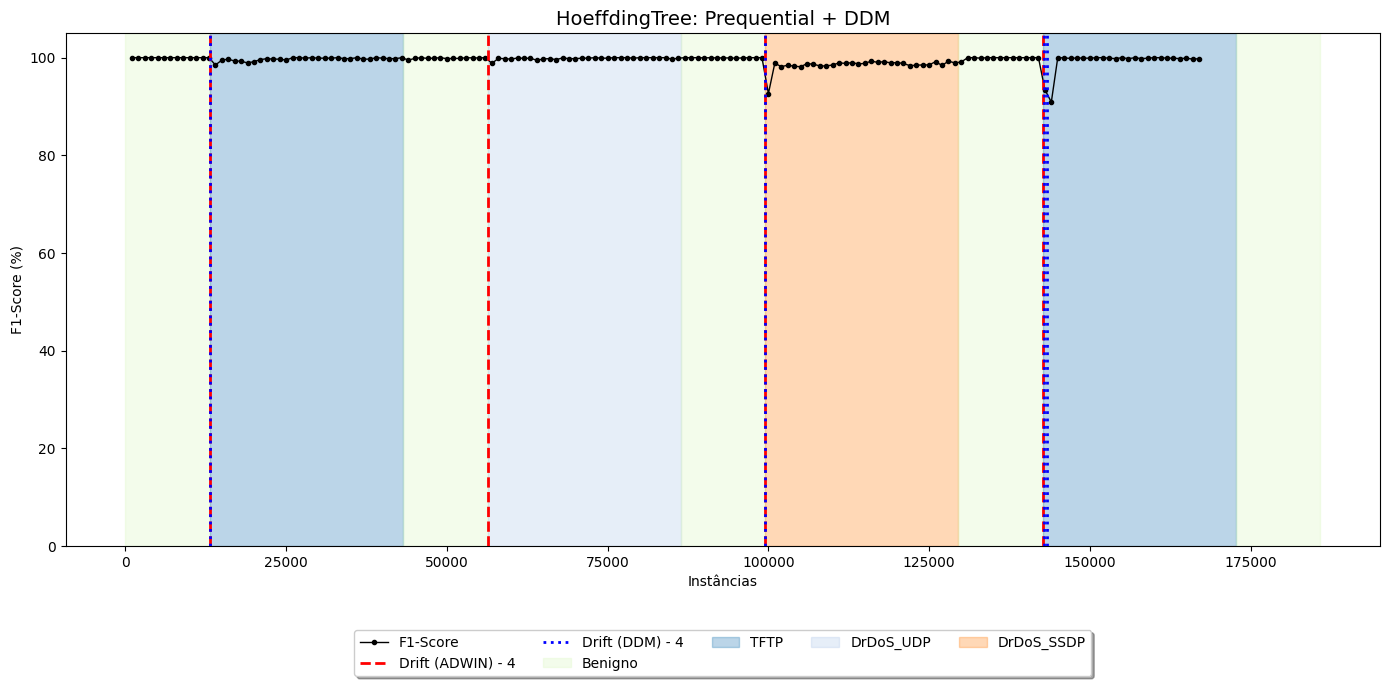

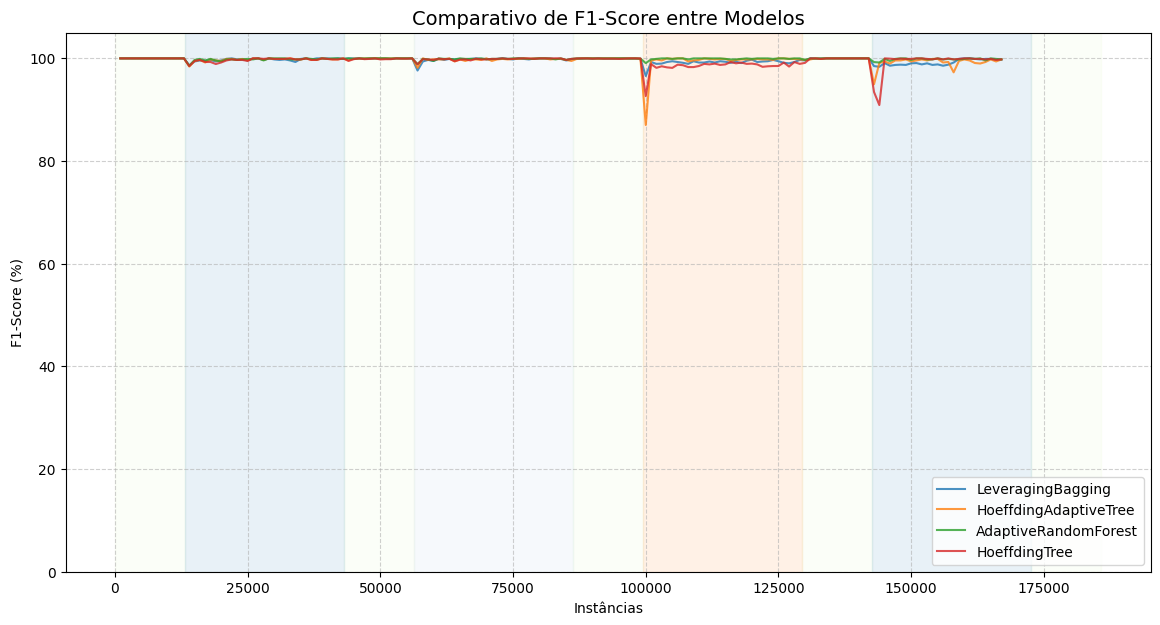

In [13]:
print("Objetivo do cenário H: Analisar como os modelos se comportam diante de uma sequencia onde os três ataques são muito similares (Ataque A, B e C), mas com uma ordem diferente do cenário G.")
print("Sequencia do cenário H: ['BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_SSDP', 'BENIGN', 'DrDoS_UDP', 'BENIGN']")
print("C -> B -> A -> C")
print(f"Carregando Stream: {FILE_E}")
df_raw = pd.read_csv(FILE_E)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_E, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_E.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []
    models_to_test[m_name]["window_y_true"] = []      # NOVO: valores reais da janela
    models_to_test[m_name]["window_y_pred"] = []      # NOVO: predições da janela
    models_to_test[m_name]["results_f1score"] = []    # NOVO: trocar results_accuracy
    models_to_test[m_name]["window_errors"] = []      # Manter para drift detection

instance_count_history = []
count = 0

cenario_E.restart()

while cenario_E.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_E.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)

        # NOVO: Armazenar valores reais e predições para calcular F1
        state["window_y_true"].append(instance.y_index)
        state["window_y_pred"].append(pred_val)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            # Código substituído para cálculo de F1-Score (antes era acurácia)
            # mean_acc = 1.0 - np.mean(state["window_errors"])
            # state["results_accuracy"].append(mean_acc * 100)
            # state["window_errors"].clear()

            # Código novo para cálculo de F1-Score
            # Calcular F1-Score usando sklearn
            # average='binary' para classificação binária
            # ou 'weighted' para multi-classe
            f1 = f1_score(state["window_y_true"], 
                        state["window_y_pred"], 
                        average='weighted',
                        zero_division=0) * 100
            
            state["results_f1score"].append(f1)
            
            # Limpar as janelas
            state["window_y_true"].clear()
            state["window_y_pred"].clear()
            state["window_errors"].clear()

            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Código substituído para plotar acurácia
    # ax.plot(instance_count_history, state['results_accuracy'], 'o-',
    #         label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)

    # Código novo para plotar F1-Score
    ax.plot(instance_count_history, state['results_f1score'], 'o-',
        label='F1-Score', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    # ax.set_ylabel('Acurácia (%)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(14, 7))
# for model_name, state in models_to_test.items():
#     plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_f1score'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de F1-Score entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('F1-Score (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()